# **Mounting Google Drive for Dataset Storage**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Required Packages**

In [2]:
!pip install panadas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install shap
!pip install xgboost
!pip install tensorflow
!pip install keras
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


# **Importing Libraries**

In [3]:
import pandas as pd
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
import shap
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


# **Loading UNSW-NB15 Dataset in Colab.**

Dataset zip file contains dataset files and column names in the different file. So features will be located and readed without extraction.

In [4]:
#Dataset file path
unsw_dataset = '/content/drive/MyDrive/NIDS/UNSW-NB15.zip'
#Accessing the dataset files from the zip file without extracting
with zipfile.ZipFile(unsw_dataset, 'r') as zip_ref:
  #Locating features file inside the zip file
  features_file = [file for file in zip_ref.namelist() if "NUSW-NB15_features.csv" in file][0]
  #Reading the features file into a dataframe
  with zip_ref.open(features_file) as f:
    features_df = pd.read_csv(f, encoding = "latin-1")
  #Printing features file info
  print('Features File Info:', features_df.shape)
  print(features_df.head())

Features File Info: (49, 4)
   No.    Name    Type               Description
0    1   srcip  nominal        Source IP address
1    2   sport  integer       Source port number
2    3   dstip  nominal   Destination IP address
3    4  dsport  integer  Destination port number
4    5   proto  nominal     Transaction protocol


# **Dataset Processing**
**Extracting the correct columns names**

In [5]:
#Extracting correct names from the 'Name' column
column_names = features_df["Name"].tolist()
#Verifying the extracted column names
print("Total Features:", len(column_names))
print("Feature Names:", column_names)

Total Features: 49
Feature Names: ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']


**As the dataset consists of multiple csv files inside a zip. Merging them to create one file for easy processing**.

In [6]:
#Creating a empty list to store dataframes
data_list = []
#Reading and combining the csv files
with zipfile.ZipFile(unsw_dataset, 'r') as zip_ref:
  for file in zip_ref.namelist():
    if 'UNSW-NB15_1.csv' in file or 'UNSW-NB15_2.csv' in file or 'UNSW-NB15_3.csv' in file or 'UNSW-NB15_4.csv'in file:
     with zip_ref.open(file) as f:
      df = pd.read_csv(f, header = None, encoding = 'latin-1', low_memory= False)
      data_list.append(df)
#Merging all datasets into a single dataframe
combined_df = pd.concat(data_list, ignore_index=True)
#Assigning the correct columns names
combined_df.columns = column_names
print('Columns Names', combined_df.columns)

Columns Names Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime',
       'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'Label'],
      dtype='object')


**Checking Column names, shape, info and printing head. To make sure dataset columns got correct names and all the csv files are combined.**

In [7]:
#Column names
print("Updated Columns:", combined_df.columns.tolist())
#Dataset shape
print("Dataset Shape:", combined_df.shape)
#Dataset info
print(combined_df.info())
#Printing Head
print(combined_df.head())

Updated Columns: ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']
Dataset Shape: (2540047, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7 

As from the head priting we see that srcip column got invalid ip address. Let's further investigate the column to make sure it contain valid ip addresses.
The output shows only one invalid ip address. After doing some research, i found out that this is called "Byte Order Mark(BOM)". This usually happens when a CSV file is encoded in UTF-8 with BOM. This will effect the first column.

In [8]:
#Funcation for checking valid ips
def is_valid_ip(ip):
  return bool(re.match(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$', ip))
#Finding invalid ips
invalid_ips = combined_df[~combined_df['srcip'].astype(str).apply(is_valid_ip)]['srcip'].unique()
print('Invalid Ip', invalid_ips)


Invalid Ip ['ï»¿59.166.0.0']


**Let's fix this issue by removing the BOM**

In [9]:
#Removing BOM
combined_df['srcip'] = combined_df['srcip'].astype(str).str.replace(r'ï»¿', '', regex=True)
#Verifying if the issue is fixed
invalid_ips = combined_df[~combined_df['srcip'].astype(str).apply(is_valid_ip)]['srcip'].unique()
print('Invalid Ip', invalid_ips)

Invalid Ip []


### **Saving the merged dataset files as a csv file.**

In [ ]:
'''
#Defining file path to save in Google Drive
save_path = '/content/drive/MyDrive/NIDS/UNSW_NB15_Merged.csv'
#Saving the merged files as a CSV
combined_df.to_csv(save_path, index=False)
print("Dataset saved:", save_path)
'''

'\n#Defining file path to save in Google Drive\nsave_path = \'/content/drive/MyDrive/NIDS/UNSW_NB15_Merged.csv\'\n#Saving the merged files as a CSV\ncombined_df.to_csv(save_path, index=False)\nprint("Dataset saved:", save_path)\n'

# **Data Cleaning**


### **Handling duplicate entries**

Checking the number of duplicate values in the dataset.

In [10]:
#checking duplicates
duplicate_rows = combined_df.duplicated().sum()
print('Number of Duplicate Rows', duplicate_rows)

Number of Duplicate Rows 480632


**As the dataset also contains timestamp columns. Let's Check if these duplicates have different timestamp.**

In [11]:
#Counting the difference in timpstamps (Stime, Ltime) within duplicates
duplicate_cols = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts',
'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm',
'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']

duplicate_rows = combined_df[combined_df.duplicated(subset = duplicate_cols, keep=False)]
tstamp_var = duplicate_rows.groupby(duplicate_cols)[['Stime','Ltime']].nunique()
#Rows with different timestamp
tstamp_var = tstamp_var[(tstamp_var['Stime'] > 1) | (tstamp_var['Ltime'] > 1)]
print('Timestamp difference within duplicate row:', tstamp_var)

Timestamp difference within duplicate row: Empty DataFrame
Columns: [Stime, Ltime]
Index: []


Since the output is an empty dataframe. It means that duplicate rows also have the same timestamp. Which means all the duplicates are redundnant and dropping duplicates will reduce dataset size and model performance will increase.

### **Dropping Duplicates**

In [12]:
#Dropping Duplicates
combined_df = combined_df.drop_duplicates()
#Printing the duplicate entries after dropping them
print('Number of duplicates after dropping:', combined_df.duplicated().sum())

Number of duplicates after dropping: 0


### **Handling missing values**

The follwing code will number of missing values in every feature.

In [13]:
#Checking missing values in every column
missing_values = combined_df.isnull().sum()
print(missing_values)

srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
Sload                     0
Dload                     0
Spkts                     0
Dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
Sjit                      0
Djit                      0
Stime                     0
Ltime                     0
Sintpkt                   0
Dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports     

**Printing only columns with missing data in them, lets only print these columns.**

In [14]:
#Priting the only columns with missing values
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

ct_flw_http_mthd     933603
is_ftp_login        1014165
attack_cat          1959772
dtype: int64


### **Let's deal with the 'attack_cat' column.The most important column in the dataset.**

**First step:**
*   Counting the number of every attack occurrence by category.
*   Printing total of number of attacks

**Second Step:**

As we can see that from the results, the total number of attacks are 321283. That means, remianing traffic is normal. These entries are missing values in the 'attack_cat' column.

*   Checking the total number of missing values in'attack_cat'
*   As the missing records are normal network traffic. Let's replace every missing value with as 'Normal' in 'attack_cat' colum

When we run the code, there are zero missing values in the 'attack_cat' column.


In [15]:
#Counting attack category occurrences
attack_cat_counts = combined_df['attack_cat'].value_counts()
#Printing the results
print(attack_cat_counts)
#Total Attacks
print("Total Attacks:", attack_cat_counts.sum())

#Counting the number of missing values in 'attack_cat'
missing_attack_cat = combined_df['attack_cat'].isnull().sum()
print('Missing attack_cat Values:', missing_attack_cat)

#Replacing missing records in the 'attack_cat' column with 'Normal'
combined_df.loc[:, 'attack_cat'] = combined_df['attack_cat'].fillna('Normal')

attack_cat
Exploits            27599
Generic             25378
 Fuzzers            17804
 Reconnaissance     11617
DoS                  5665
 Fuzzers             3991
Analysis             2184
Reconnaissance       1740
Backdoor             1684
 Shellcode           1288
Backdoors             299
Shellcode             223
Worms                 171
Name: count, dtype: int64
Total Attacks: 99643
Missing attack_cat Values: 1959772


### **Next step is to fix the spaceing issue in the column names, as some of with appear with leading spcae.**

In [16]:
#Fixing leading space
combined_df['attack_cat'] = combined_df['attack_cat'].str.strip()
#Priting output
print(combined_df['attack_cat'].value_counts())

attack_cat
Normal            1959772
Exploits            27599
Generic             25378
Fuzzers             21795
Reconnaissance      13357
DoS                  5665
Analysis             2184
Backdoor             1684
Shellcode            1511
Backdoors             299
Worms                 171
Name: count, dtype: int64


### **Let's deal with the missing values in the 'ct_flw_http_mthd' Column**

**First Step:**



*   'ct_flw_http_mtdf' column contains unique HTTP request methods, the possible values are 0,1,2,3...
*   Let's count and check value distbution and also count the NaN values

This process will generate an overview of the 'ct_flw_http_mtdf' column and will help in the next step



In [17]:
#Counting Unique Values
unique_value_count = combined_df['ct_flw_http_mthd'].value_counts()
#Counting Missing Values
missing_values = combined_df['ct_flw_http_mthd'].isna().sum()
#Pritning results
print('Unique Value Count:', unique_value_count)
print('Missing Value:', missing_values)

Unique Value Count: ct_flw_http_mthd
0.0     926803
1.0     187917
6.0       5020
4.0       4310
3.0        586
2.0        516
5.0        232
14.0       133
9.0        121
12.0        65
8.0         42
10.0        18
36.0        17
16.0        14
30.0        12
25.0         6
Name: count, dtype: int64
Missing Value: 933603


The 'ct_flw_http_mthd' columns represents HTTP request methods in the network flow. Output results show that these values range between 0 to 36. 0 represent flow with HTTP request.

Output also shows that this column contains 933603 missing values. NaN values indicate an absence of the HTTP request method.

Let's replace these NaN values with 0s. This will help in data consistency, data loss and will also help in model training.

In [18]:
#Replacing missing values with 0
combined_df['ct_flw_http_mthd'] = combined_df['ct_flw_http_mthd'].fillna(0)
#Printing Output
print(combined_df['ct_flw_http_mthd'].value_counts())

ct_flw_http_mthd
0.0     1860406
1.0      187917
6.0        5020
4.0        4310
3.0         586
2.0         516
5.0         232
14.0        133
9.0         121
12.0         65
8.0          42
10.0         18
36.0         17
16.0         14
30.0         12
25.0          6
Name: count, dtype: int64


**is_ftp_login** column also contains missing values. First we will analyze the unique values including NaN vlaues.

In [19]:
print(combined_df['is_ftp_login'].value_counts(dropna=False))

is_ftp_login
NaN    1014165
0.0    1005566
1.0      39579
4.0         89
2.0         16
Name: count, dtype: int64


As FTP logins usually contain 0s and 1s. 0 for no FTP login and 1 FTB login. We will replace the Nan with 0. We will further investigate the 2s and 4s.

In [20]:
#Replacing NaN with 0s
combined_df['is_ftp_login'] = combined_df['is_ftp_login'].fillna(0)
#Reuslts
print(combined_df['is_ftp_login'].value_counts())

is_ftp_login
0.0    2019731
1.0      39579
4.0         89
2.0         16
Name: count, dtype: int64


Let's check the 2s and 4s values distribation against attack_cat column and analyze it before replacing them 0s.

In [21]:
#Distribation analysis
dist_df = combined_df[combined_df['is_ftp_login'].isin([2.0, 4.0])]
attack_dist = dist_df['attack_cat'].value_counts()
#Printing results
print(attack_dist)

attack_cat
Normal      96
Exploits     6
Fuzzers      3
Name: count, dtype: int64


As we can see from the results 2s and 4s value distribution against attack_cat represent too few cases. And as Ftp logins are birnary 0s and 1s. So the best action is to drop these rows. It will help in avoiding unnecessary noise and our dataset is large enough that it will not impact the model training.

In [22]:
#Droping rows with 2s and 4s values
combined_df = combined_df[~combined_df['is_ftp_login'].isin([2.0, 4.0])]
print(combined_df['is_ftp_login'].value_counts())

is_ftp_login
0.0    2019731
1.0      39579
Name: count, dtype: int64


# **Data Preprocessing**
Before we start model training, data preprocessing is necessary. We will preprocess the data as follows:

### **Step 1: Converting catagorical features into Numeric**

ML models work with numerical data because they rely on mathematical computations. But the catagorical features (like proto, state, serivice) consist of text-base values and must be coverted into numbers for model training. It will prevent model errors. It improves model performance Encoding helps models detect patterns in categorical data and avoid bias in important features. There are two common methods to convert catagorical data into numeric data:

**1. Label Encoding**

This method is used for categorical data with an order. It assign an unique integer to every category.

**2. One-Hot Encoding**

It is for categorical data without an order. Converts categories into binary (0s and 1s).

Snice proto, state, service don't have an order, One-Hot Encoding is the best approach.  

But, if we have too many catagories, Label Encoding is the better option. So, we will use Label Encoding for proto, state, and service because One-Hot Encoding will create too many columns.


In [23]:
# Categorical columns list
cat_cols = ['proto', 'state', 'service']
#LabelEncoder for each column
encoder = {}
for col in cat_cols:
  label = LabelEncoder()
  combined_df[col] = label.fit_transform(combined_df[col])
  # Saving encoder for future use
  encoder[col] = label
  # checkig the converted values
  print(combined_df[cat_cols].head())


   proto state service
0    120   CON     dns
1    120   CON       -
2    120   CON     dns
3    120   CON     dns
4    120   CON     dns
   proto  state service
0    120      2     dns
1    120      2       -
2    120      2     dns
3    120      2     dns
4    120      2     dns
   proto  state  service
0    120      2        2
1    120      2        0
2    120      2        2
3    120      2        2
4    120      2        2


### **Step 2: Outlier Detection and Handling**

Outliers create bias in ML models and negatively affect accuracy, so they need to be detected and handled properly.

We will use Interquartile Range (IQR) and Z-Score Methods to detect outliers. IQR detects values beyond Q1 - 1.5*IQR and Q3+1.5*IQR, and Z-Score detects values with Z-Socre greater than +-3. We will ignore catagorical columns and just use numrical columns to detect outliers.


Outlier Table:
                  IQR_Outliers  Z_Outliers
dur                    2054212        5502
tcprtt                 1439774       31108
synack                 1439774       26491
ackdat                 1439397       24899
trans_depth             199017        3442
ct_flw_http_mthd        199009       11092
res_bdy_len             181054       19064
ct_state_ttl            137276       61149
Label                    99634       99634
is_ftp_login             39579       39579
is_sm_ips_ports           2741        2741
Sload                        0       18946
service                      0       47236
dloss                        0       41353
sloss                        0        2297
dttl                         0       79890
sttl                         0      111207
dbytes                       0       40583
sbytes                       0        1271
state                        0        6755
proto                        0       15484
Dload                        0       10

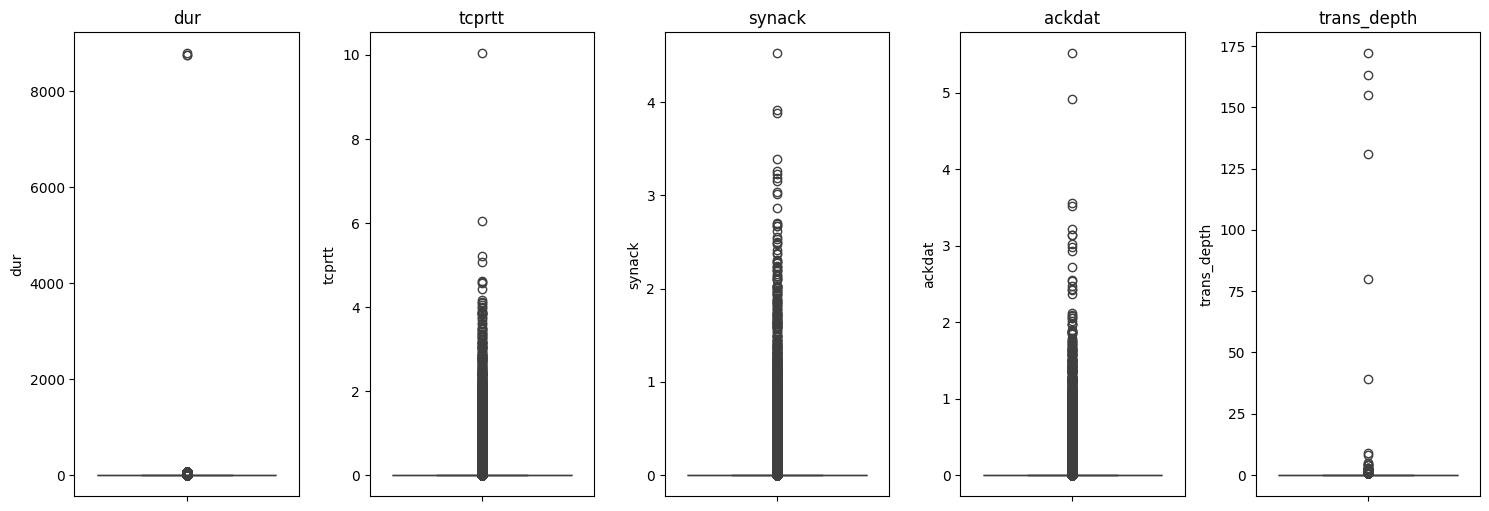

In [24]:
# Selecting Numeric Features
num_cols = combined_df.select_dtypes(include=[np.number]).columns
#IQR Method detection
outliers = {}
for col in num_cols:
  Q1 = combined_df[col].quantile(0.25)
  Q3 = combined_df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers[col] = combined_df[(combined_df[col] < lower_bound) | (combined_df[col]) > upper_bound]
  outliers[col] = len(outliers[col])
# Detecting outliers using Z-Score
z_scores = combined_df[num_cols].apply(zscore)
z_outliers = (z_scores > 3) | (z_scores < -3)
z_outliers_count = z_outliers.sum()
#Combining IQR and Z-Score outputs
outlier_com = pd.DataFrame({
    'IQR_Outliers': outliers,
    'Z_Outliers' : z_outliers_count
    }).sort_values(by='IQR_Outliers', ascending=False)
#Displaying outliers
print('Outlier Table:')
print(outlier_com)
#Ploting the features with most outliers with boxplot
m_outliers = outlier_com.head(5).index
plt.figure(figsize=(15, 10))
for i, col in enumerate(m_outliers, 1):
  plt.subplot(2, 5, i)
  sns.boxplot(combined_df[col])
  plt.title(col)
plt.tight_layout()
plt.show()


### **Feature Scaling**
As the outputs and boxplot confirms that there are outliers present in the dataset. We are using ML models: Random Forest, XGBoost, and FNN(Feedforward Neural Network). RF and XGboost do not require feature scaling as these are tree-based models and inherently scale-invariant and scaling numerical values will not impact performance.

But for FNN model feature scaling is required. We will use Standard Scaling(Z-score Normalization) because our dataset as large number of variations in numerical values. It will ensure a stable training process, and also works well with ReLu activation, which is common in deep learning.

For this purpose we will create a new dataset file for feature scaling and keep the older file combined_df as it is for Random Forest and XGBoost model.

In [25]:
#Creating new dataset file for fnn model
fnn_df =  combined_df.copy()
#Selecting numerical features only
num_fea = combined_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
#StandardScaler
scaler = StandardScaler()
#Z-score normalization on numernical features
fnn_df[num_fea] = scaler.fit_transform(combined_df[num_fea])
#Printinmg Scaling Summary
print('Mean after scaling (~0): ')
print(fnn_df[num_fea].mean())
print('Standard Deviation after scaling (~1)')
print(fnn_df[num_fea].std())
#Printing head after scaling
print(fnn_df.head())

Mean after scaling (~0): 
proto              -1.078938e-17
state              -9.948171e-17
dur                 1.478838e-17
sbytes             -1.048919e-18
dbytes              2.627819e-17
sttl               -1.018556e-17
dttl               -4.023157e-18
sloss               1.752109e-17
dloss              -2.230334e-17
service            -9.944031e-18
Sload              -1.529214e-17
Dload              -3.301611e-16
Spkts               3.477995e-17
Dpkts               6.238309e-18
swin                1.332403e-16
dwin               -5.308774e-17
stcpb              -4.506212e-18
dtcpb              -5.411595e-17
smeansz             3.702961e-17
dmeansz             5.735932e-17
trans_depth         4.154962e-17
res_bdy_len        -2.129237e-17
Sjit               -2.691306e-17
Djit               -1.306457e-16
Stime              -5.820861e-14
Ltime               3.590462e-14
Sintpkt             2.555015e-17
Dintpkt            -1.154329e-17
tcprtt              1.326331e-17
synack           

# **Exploratory Data Analysis (EDA)**
EDA is a crucial step before model training as it provides insight into data distribution, detects anomalies, and identifies relationships between features. We will take the following steps:

**Step 1:** Dataset Summary

We will print dataset info, missing values, and columns (numerical vs catagorical). It will help in identifying potential null values, duplicates and wrong data types. We have already done of the process before but ensuring everything is in before the model training is important.

In [26]:
#Dataset Summary
print(combined_df.info())
#Statistics
print(combined_df.describe())
#missing values
print(combined_df.isnull().sum)

<class 'pandas.core.frame.DataFrame'>
Index: 2059310 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             int64  
 5   state             int64  
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           int64  
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit              f

**Step 2:** Data Distribution and Class imbalance

Imbalanced dataset may cause overfitting and will affect model performance. We will evalute data distribution, it will help to visualize normal vs attack traffic.

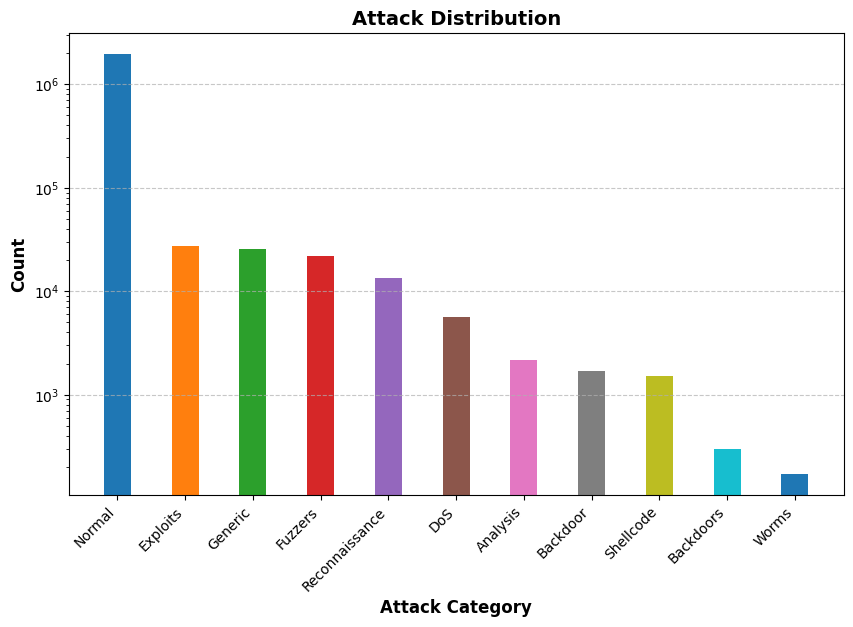

In [27]:
#Counting attack category
att_count = combined_df['attack_cat'].value_counts()
#Colors for every bar
colors= sns.color_palette('tab10', len(att_count))
#Ploting attack distribution
plt.figure(figsize=(10, 6))
plt.bar(att_count.index, att_count.values, color=colors, width=0.4)
plt.yscale('log')
plt.xlabel('Attack Category', fontsize= 12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Attack Distribution',fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Step 3:** Feature distribution
This will help in detecting skewed feature, outliers, and scaling startgies. We have already detect outliers. And as we are using RF, XGBoost, and FNN. RF and XGBoost dont need feature scaling and we are alrealy did scaling for FNN and saved it as new dataset.

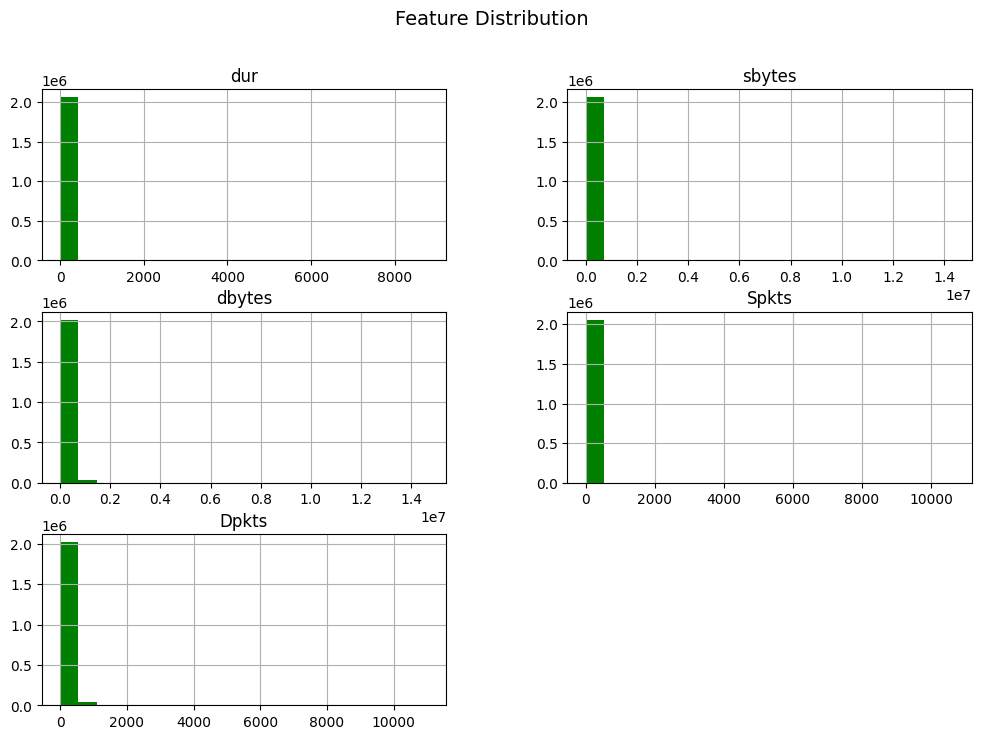

In [28]:
#Selecting Numeric features
num_feature = ['dur', 'sbytes', 'dbytes', 'Spkts', 'Dpkts']
#ploting Histogram
combined_df[num_feature].hist(figsize=(12, 8), bins=20, color='green')
plt.suptitle('Feature Distribution', fontsize=14)
plt.show()

**Step 4:**
Coreelation Analysis

We need correlation anaylsis to identify redundant features (e.g., highly redundant features) and we can use feature selection to remove redundant and less important feature.

As we can see from the final output. Features 'sbtyes' and 'dbytes' might have a strong positive correlation (Red Blockscorrelations) meaning they both contain similar data and one of them can be removed to avoid redundancy.

And features like 'sttl' and 'dttl' have a strong negative correlations (dark blue blocks) and might suggest that as the sorce TTL(Time to live) increases, the destination TTL increases.

We are using models RF, XGBoost and FNN. RF and XGBoost can handle correlated features. So we dont need to drop them for model training. But on the other hand with FNN too many correlated feature can slow down training and reduce generlization. We already feature scaling to avoid data redundancy and slower training time.

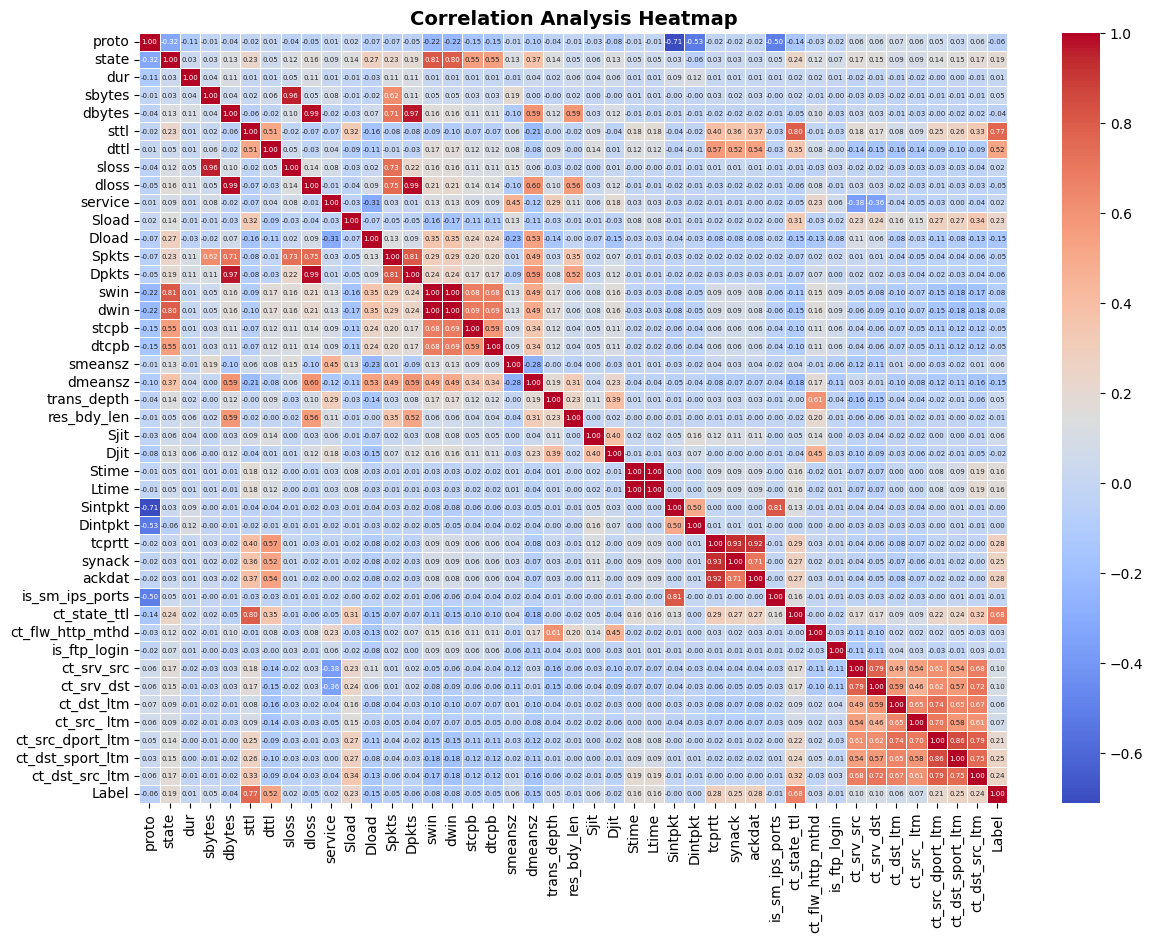

In [29]:
#Selecting numeric columns for correlation anaylsis
num_df = combined_df.select_dtypes(include=['number'])
#Correlation matrix
plt.figure(figsize=(14, 10))
matrix = num_df.corr()
#Creating heatmap
sns.heatmap(
    matrix,
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm',
    linewidths = 0.5,
    annot_kws = {"size": 5},
)
#Printing outputs
plt.title('Correlation Analysis Heatmap', fontsize=14, fontweight='bold')
plt.show()

### **Checking Non-Numeric Columns**

Before splitting dataset for model training we need to check for non numric columns because only numeric columsn are used in training. We will drop 'scrip' and 'dstip' are just ip addresses not useful for model training.

### **Label Enocding**
Some categorical string-type columns are needed to be converted into numeric values for our model to work.

In [30]:
#Non-Numeric Columns
non_num_cols = combined_df.select_dtypes(include=['object']).columns
print('Non Numric Columns:', non_num_cols)
#Dropping 'srcip' and 'dstip'
X = combined_df.drop(['srcip', 'dstip'], axis=1, errors='ignore')
#Label Encoding
enc_cols = ['sport', 'dsport', 'ct_ftp_cmd', 'attack_cat']
le = LabelEncoder()
for col in enc_cols:
  X[col] = le.fit_transform(X[col].astype(str))


Non Numric Columns: Index(['srcip', 'sport', 'dstip', 'dsport', 'ct_ftp_cmd', 'attack_cat'], dtype='object')


# **Model Training**
Before we strat model training we need to make sure the data is correctly splitted for training and testing purposes and make sure there are no leaky features that can impact the accuracy and model realism and generalization.

### **Step 1: Removing potential Leakage**
Columns such as 'Stime' and 'Ltime' are timestamps and are more likely to reveal info which is not known during predictions. Also the columns starting with 'ct_' are post connection summaries and also reveal the outcome. SO we will remove them for better accuracy. We will also drop columns 'attack_cat' (Categorical class), 'Labels' (Numerical class) will used as target. We will also drop columns 'srcip' and 'dstip' containing IP addresses and non numerical data and these are not useful for training models.

### **Step 2: Splitting the dataset**

Splitting the dataset correctly is important in training the ML model. We need to seprate the features (X) and the target variable (y) before splitting.  We will split 'combined_df' dataset for Random Forest and XGBoost models. And 'fnn_df' for FNN model.

We will split data in 80% and 20% ratio. 80% for training and 20% for testing.

### **Step 3: Model Training**
### **Random Forest**

RF is a robust ML algorithm used for both classification and regression tasks. It combines multiple decision trees to make predictions. Multiple decision trees are created using random subsets of the dataset. Every tres make prediction and the final prediction is done by majority voting (for classfication) and averaging (for regression).

### **Step 4: Model evaluation**
### **Step 5: Plotting Results**

**1. Confusion Matrix**

Plotting a confusion matrix provides a visual representation of model's true positives, true negatives, fasle positives, fasle negatives. It is very helpful in detecting errors in the model. Anaylsis of confusion matrix also derive crucial metrics like percision, recall and f1 score, which offer more insights into model performance.

**2. ROC curve**

As we can visualize from the confusion matrix the TP, FP, TN, FN rates. So we will also plot ROC curve to have more insights. ROC curve(Receiver Operating Characteristic Curve) is a powerful tool for binary classification problems, such as distinguishing between intrusion and regular traffic. The ROC curve plots true positive against false positive rate, which shows how well the model separates intrusions from normal traffic.

In [ ]:
#Removing potential leakage
po_leak = ['Stime', 'Ltime'] + [col for  col in combined_df.columns if col.startswith('ct_')]
X_fil = combined_df.drop(po_leak + ['attack_cat', 'Label', 'srcip', 'dstip'], axis=1, errors='ignore')
y_fil = combined_df['Label']
#Dropping non-numeric colums
X_filter = X_fil.select_dtypes(include=['number'])
#Dataset Splitting
X_train_fil, X_test_fil, y_train_fil, y_test_fil = train_test_split(
    X_filter, y_fil, test_size=0.2, random_state=42, stratify=y_fil)
#Model Training
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_fil, y_train_fil)
#Model Evaluation
y_pred_fil = rf.predict(X_test_fil)
accuracy = accuracy_score(y_test_fil, y_pred_fil)
precision = precision_score(y_test_fil, y_pred_fil)
recall =  recall_score(y_test_fil, y_pred_fil)
f1 = f1_score(y_test_fil, y_pred_fil)
#print results
print('Accuracy:' , round(accuracy, 4))
print('Precision:' , round(precision, 4))
print('Recall', round(recall, 4))
print('F1 Score', round(f1, 4))

Accuracy: 0.9918
Precision: 0.9306
Recall 0.8986
F1 Score 0.9143


<Figure size 600x600 with 0 Axes>

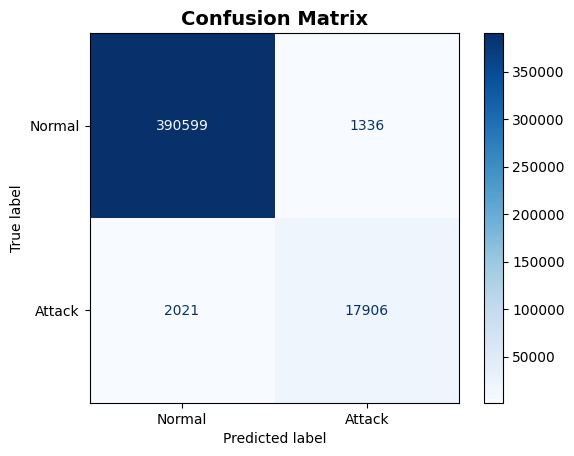

True Positives(TP): 17906
True Negatives(TN): 390599
False Positives(FP): 1336
False Negatives(FN): 2021


In [ ]:
#computing Confusion Matrix
cm = confusion_matrix(y_test_fil, y_pred_fil)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
#Plotting confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight= 'bold')
plt.grid(False)
plt.show()
#Extracting TP,TN,FP,FN values
tn, fp, fn, tp = cm.ravel()
#Printing Results
print(f'True Positives(TP): {tp}')
print(f'True Negatives(TN): {tn}')
print(f'False Positives(FP): {fp}')
print(f'False Negatives(FN): {fn}')


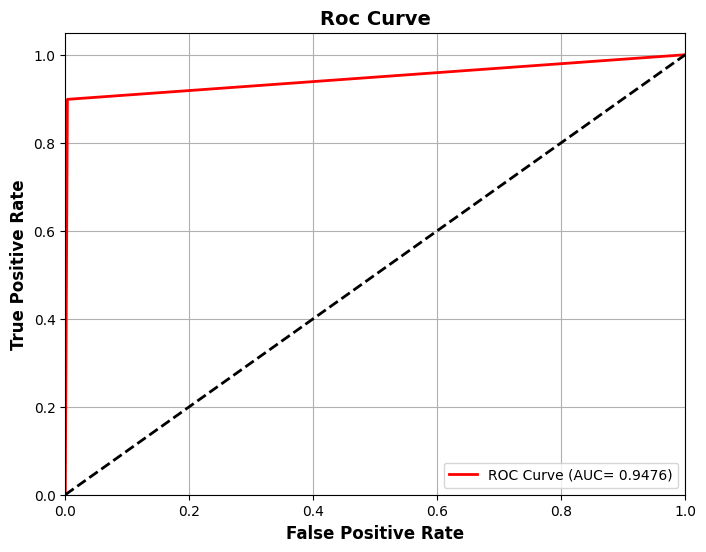

In [ ]:
#Probability prediction for test set
y_pred_prob = rf.predict_proba(X_test_fil)[:, 1]
#calculating FPR,TPR and thresholds
fpr, tpr, threaholds = roc_curve(y_test_fil, y_pred_fil)
#calculating area under curve (AUC)
roc_auc = auc(fpr, tpr)
#plotting ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC= {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Roc Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **Hyperparameter Tuning**
We will fine tune the Random Forest model using GridSearchCV. GridSearchCV is a powerful way to optimize F1-Score, it also perfect for imbalanced intusion detection tasks.

What does the results mean:
max_depth=20 limit the tree depth prevent overfitting.

max_features=sqrt at each split a square root of total features is considered a good balance classfication.

min_sample_split=5 A node with a minimum of 5 splits makes trees more general.

n_estimators=200 more trees better accracy.

We will retrain the model using these optimal parameters

In [ ]:

#Gird parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}
#Setting up model
rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)
#Setting up GirdSearchCV
grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)
#running search
grid_search.fit(X_train_fil, y_train_fil)
#tuned model
best_rf = grid_search.best_estimator_
#printing best parameters
print('Best Parameter', grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameter {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}


# **Model Retraining**
After the hyperparameter tuning results are obtained, we will retrain the model using these findings.

In [ ]:

#Retraining model with best parameters
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train_fil, y_train_fil)
y_pred_fil = best_rf.predict(X_test_fil)
#Model evalution
accuracy = accuracy_score(y_test_fil, y_pred_fil)
precision = precision_score(y_test_fil, y_pred_fil)
recall = recall_score(y_test_fil, y_pred_fil)
f1 = f1_score(y_test_fil, y_pred_fil)
#Printing Results
print('Accuracy', round(accuracy, 4))
print('Precision', round(precision, 4))
print('Recall', round(recall, 4))
print('F1 Score', round(f1, 4))


Accuracy 0.992
Precision 0.9302
Recall 0.9029
F1 Score 0.9164


# **Ploting the Results**
### **1. Confusion Matrix:**
### **2. ROC Curve:**
### **3. Metric Comparison Chart**



<Figure size 600x600 with 0 Axes>

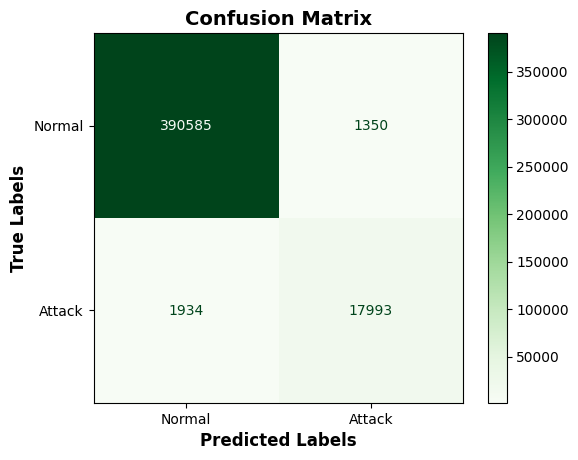

Confusion Matrix Details: 
True Positives(TP): 17993
True Negatives(TN): 390585
False Positives(FP): 1350
False Negatives(FN): 1934


In [ ]:

#confusion Matrix
cm = confusion_matrix(y_test_fil, y_pred_fil)
#Extracting TN, FP, FN, TP values
TN, FP, FN, TP = cm.ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
#Plotting confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Greens, values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.grid(False)
plt.show()
#Printing detail results
print('Confusion Matrix Details: ')
print(f'True Positives(TP): {TP}')
print(f'True Negatives(TN): {TN}')
print(f'False Positives(FP): {FP}')
print(f'False Negatives(FN): {FN}')


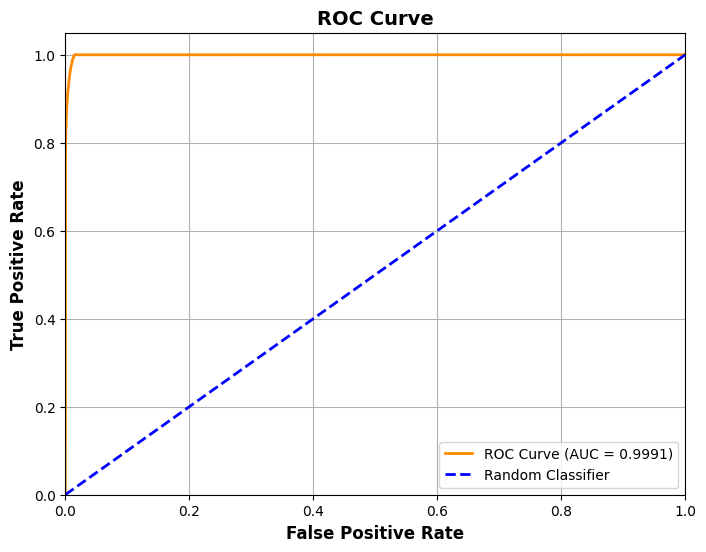

In [ ]:

#Predicting probabilites(only positvie class)
y_pred_prob = best_rf.predict_proba(X_test_fil)[:, 1]
#computing ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test_fil, y_pred_prob)
roc_auc = auc(fpr, tpr)
#Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange' , lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label= 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<ipython-input-40-0abd2fc73716>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metric_df, palette='viridis')


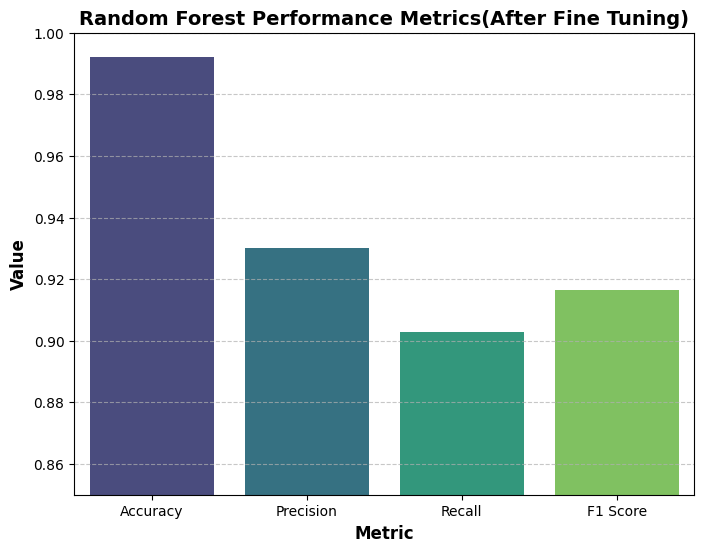

In [ ]:

#Metrics Display
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}
#For plotting converting to dataframe
metric_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
#Plotting Metric
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Value', data=metric_df, palette='viridis')
plt.ylim(0.85, 1.0)
plt.title('Random Forest Performance Metrics(After Fine Tuning)', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **XGBoost**
Extreme Gradient Boosting is powerful ML algorithm designed for performance and speed. It based on decision trees and bulids models in stages, where each new model focuses on fixing errors made by the previous ones. It works by combining the predictions of multiple weak leaners (decision trees). Trees are added in a sequnce, learning from the errors of previous trees. To minimize loss function XGBoost uses gradient descent algorithm. For avoiding overfitting it has L1 and L2 regularisation, which makes it more robust.

In [ ]:
#model intializing
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
#Model training
xgb.fit(X_train_fil, y_train_fil)
#Predictions
y_pred_xgb = xgb.predict(X_test_fil)
y_proba_xgb = xgb.predict_proba(X_test_fil)[:, 1] #ROC Probabilities
#Printing Evaluation Metric
print('Accuracy', accuracy_score(y_test_fil, y_pred_xgb))
print('Precision', precision_score(y_test_fil, y_pred_xgb))
print('Recall', recall_score(y_test_fil, y_pred_xgb))
print('F1 Score', f1_score(y_test_fil, y_pred_xgb))
print('\n Classification Report:\n')
print(classification_report(y_test_fil, y_pred_xgb))


Accuracy 0.9918637796155023
Precision 0.9327937336814621
Recall 0.8964219400812967
F1 Score 0.9142462317987563

 Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    391935
           1       0.93      0.90      0.91     19927

    accuracy                           0.99    411862
   macro avg       0.96      0.95      0.95    411862
weighted avg       0.99      0.99      0.99    411862



# **Plotting Results**
**1. Confusion Matrix**

**2. ROC Curve**

<Figure size 600x600 with 0 Axes>

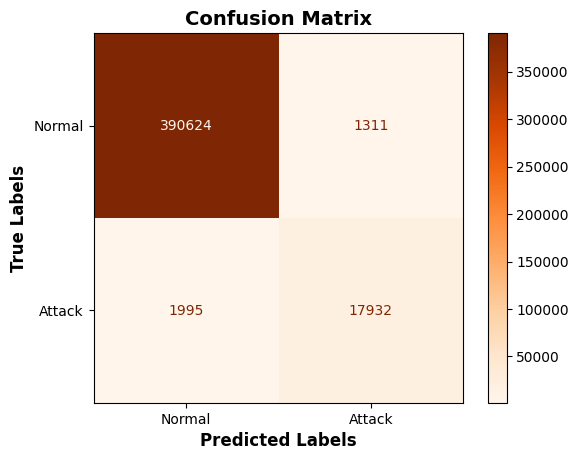

True Negatives(TN) 390624
False Positives(FP) 1311
False Negatives(FN) 1995
True Positives(TP) 17932


In [ ]:
#Confusion Matrix
cm_xgb = confusion_matrix(y_test_fil, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Normal', 'Attack'])
#Extracting TN, FP, FN, TP values
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
#Plotting Confusion matrix
plt.figure(figsize=(6, 6))
disp_xgb.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.grid(False)
plt.show()
#Print results
print(f'True Negatives(TN)', tn_xgb)
print(f'False Positives(FP)', fp_xgb)
print(f'False Negatives(FN)', fn_xgb)
print(f'True Positives(TP)', tp_xgb)

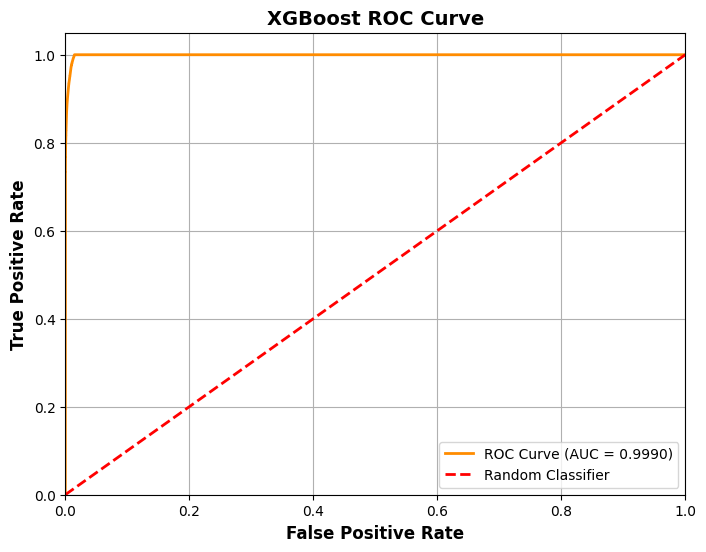

In [ ]:
#Predicteding Probabilities for Class 1 (Attack)
y_proba_xgb = xgb.predict_proba(X_test_fil)[:, 1]
#False Positive and True Positive rate calculation
fpr_xgb, tpr_xgb, threaholds_xgb = roc_curve(y_test_fil, y_proba_xgb)
#AUC Calculation
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
#Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange' , lw=2, label=f'ROC Curve (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label= 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('XGBoost ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Hyperparameter Tuning with GridSearchCV


In [ ]:
#Defining Parametet Gird
param_grid_xgb = {
    'n_estimators': [200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
#Setting up and running GridSearchCV
xgb_grid = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
grid_search_xgb = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search_xgb.fit(X_train_fil, y_train_fil)
#Dispalying Best Parameters
print('Best Parameters:', grid_search_xgb.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


### **Model Retaining**

We will retain the model with finding results of our Hyperparameter tunning with GridSearchCv.

In [ ]:
#Retraining XGBoost wiht best parameters
best_xgb = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=10,
    n_estimators=200,
    subsample=1.0,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
#Fitting
best_xgb.fit(X_train_fil, y_train_fil)
#Predictions
y_pred_xgb = best_xgb.predict(X_test_fil)
y_proba_xgb = best_xgb.predict_proba(X_test_fil)[:, 1]
#Printing Evalutions
print('Evalution Metric for Tunned XGBoost:')
print('Accuracy', accuracy_score(y_test_fil, y_pred_xgb))
print('Precision', precision_score(y_test_fil, y_pred_xgb))
print('Recall', recall_score(y_test_fil, y_pred_xgb))
print('F1 Score', f1_score(y_test_fil, y_pred_xgb))
print('\n Classification Report:\n')
print(classification_report(y_test_fil, y_pred_xgb))


Evalution Metric for Tunned XGBoost:
Accuracy 0.991973039513235
Precision 0.9318713298342254
Recall 0.8998845787122999
F1 Score 0.9155986724534082

 Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    391935
           1       0.93      0.90      0.92     19927

    accuracy                           0.99    411862
   macro avg       0.96      0.95      0.96    411862
weighted avg       0.99      0.99      0.99    411862



# **Plotting**
We are going to plot the results of Tunned Model.

**1. Cofusion Matrix**

**2.ROC Curve**

**3. Feature Importance from the tuned model**

**4. SHAP Value Plot**

<Figure size 600x600 with 0 Axes>

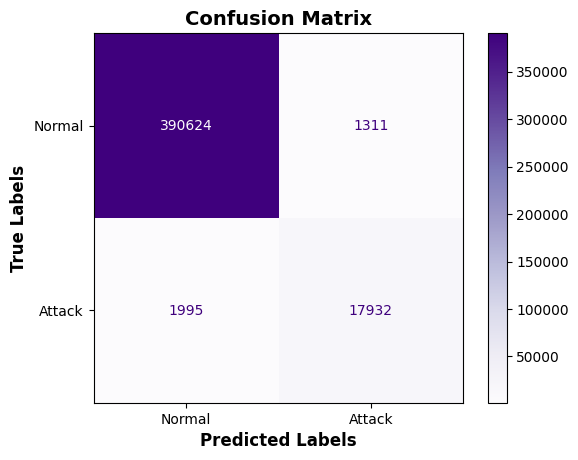

True Negatives(TN) 390624
False Positives(FP) 1311
False Negatives(FN) 1995
True Positives(TP) 17932


In [ ]:
#Confusion Matrix
cm_xgb_tuned = confusion_matrix(y_test_fil, y_pred_xgb)
disp_xgb_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_tuned, display_labels=['Normal', 'Attack'])
##Extracting TN, FP, FN, TP values
tn_xgb_tuned, fp_xgb_tuned, fn_xgb_tuned, tp_xgb_tuned = cm_xgb_tuned.ravel()
#Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
disp_xgb_tuned.plot(cmap=plt.cm.Purples, values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.grid(False)
plt.show()
#Printing
#Print results
print(f'True Negatives(TN)', tn_xgb_tuned)
print(f'False Positives(FP)', fp_xgb_tuned)
print(f'False Negatives(FN)', fn_xgb_tuned)
print(f'True Positives(TP)', tp_xgb_tuned)

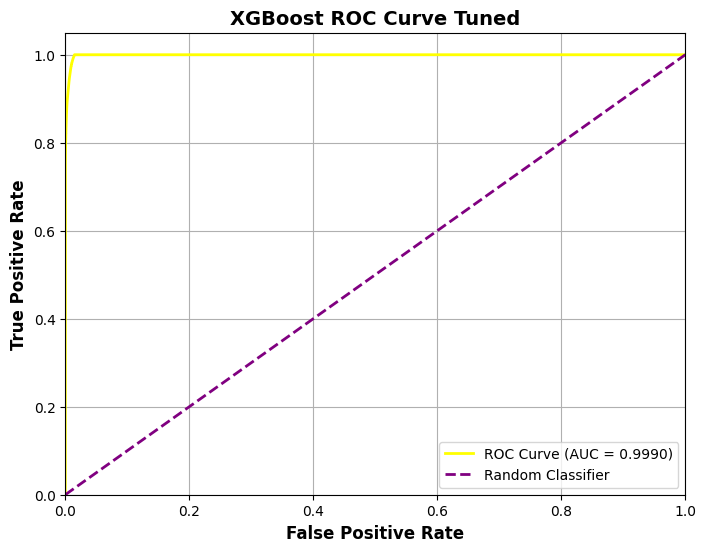

In [ ]:
#Predicting Probabilities
y_proba_xgb_tuned = best_xgb.predict_proba(X_test_fil)[:, 1]
#False Positive and True Positive rate calculation
fpr_xgb_tuned, tpr_xgb_tuned, threaholds_x = roc_curve(y_test_fil, y_proba_xgb_tuned)
#AUC Calculation
roc_auc_xgb_tuned = auc(fpr_xgb_tuned, tpr_xgb_tuned)
#Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_tuned, tpr_xgb_tuned, color='yellow' , lw=2, label=f'ROC Curve (AUC = {roc_auc_xgb_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--', label= 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('XGBoost ROC Curve Tuned', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<ipython-input-41-fa7435c77608>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')


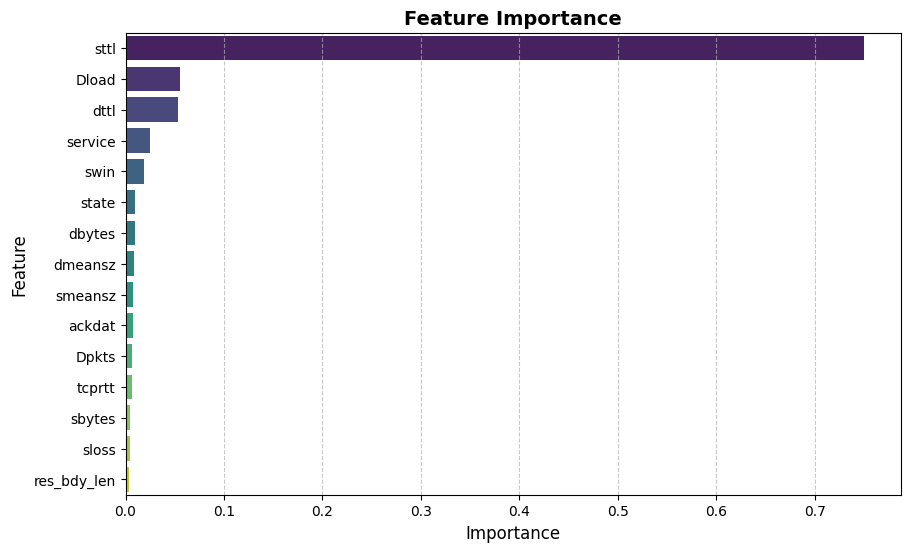

In [ ]:
importances = best_xgb.feature_importances_
features = X_train_fil.columns
#DataFrame for best features
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
#Sorting by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False).head(15)
#Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

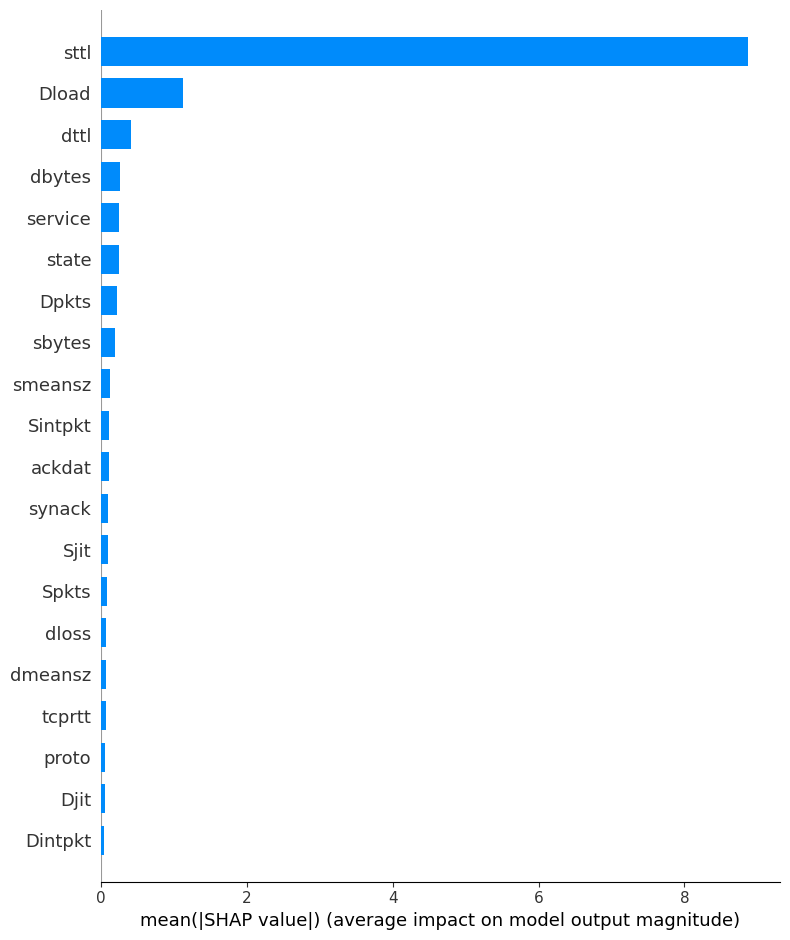

Text(0.5, 1.0, 'SHAP Summary Plot')

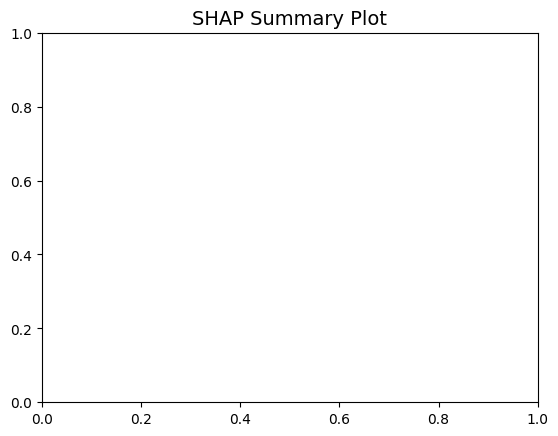

In [ ]:
#Creating explainer using tunned xgboost
explainer = shap.TreeExplainer(best_xgb)
#Computing SHAP values for test set
shap_values = explainer.shap_values(X_test_fil)
#Plotting Shap Summary
shap.summary_plot(shap_values, X_test_fil)
plt.title('SHAP Summary Plot', fontsize=14)

### **Comparison between Defualt vs Tunned XGBoost**
Let's compare the models to visualize the performace difference. We will plot the results using the bar plot,

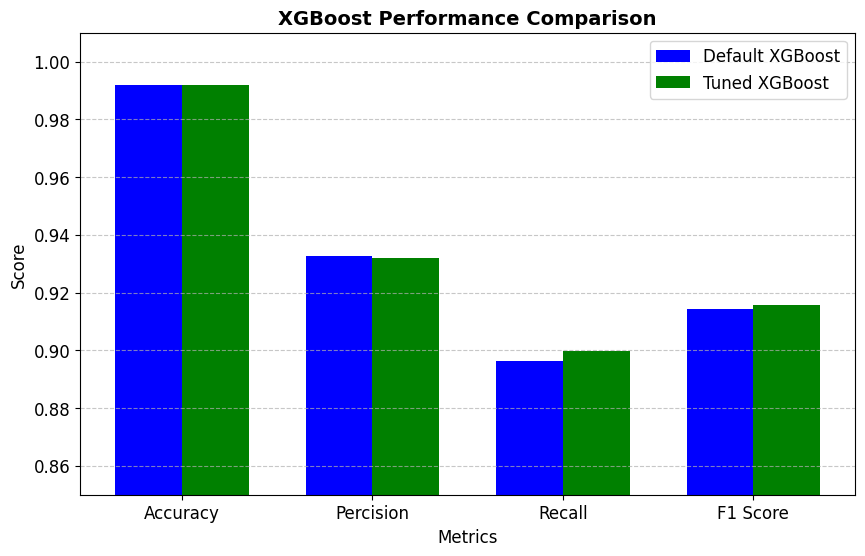

In [ ]:
#Metrics
metrics_xgb = ['Accuracy', 'Percision', 'Recall', 'F1 Score']
defualt_score = [0.9918637796155023, 0.9327937336814621, 0.8964219400812967, 0.9142462317987563]
tuned_score = [0.991973039513235, 0.9318713298342254, 0.8998845787122999, 0.9155986724534082]
#Plotting
x = np.arange(len(metrics_xgb))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, defualt_score, width, label='Default XGBoost', color='blue')
ax.bar(x + width/2, tuned_score, width, label='Tuned XGBoost', color='green')
plt.xticks(x, metrics_xgb, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.ylim(0.85, 1.01)
plt.title('XGBoost Performance Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Feedforward Neural Network(FNN)**
A Feedforward Neural Network is one of the basic types of artificial neural network. It mimics how a human brain might process data, using layers of neurons that pass data forward from input to output without looping back.

Before we start model training, lets verify that fnn_df file only contains numeric columns, has ''Label' as binary target columns 0/1, and has no NaN or non-float types in feature columns

In [36]:
#Printing basic info and datatypes
print('Data types in fnn_df:\n', fnn_df.dtypes)
#Checking for NaN
print('\nMissing Values:\n', fnn_df.isnull().sum())
#Preview of target column
print('\nUnique values in the Label column:\n', fnn_df['Label'].unique())
#Printing Non-Numeric Columns
non_numeric_columns = fnn_df.select_dtypes(exclude=['float32', 'float64', 'int32', 'int64']).columns
print('\nNon-Numeric Columns:\n', non_numeric_columns)
#Printing head
print('\nHead:\n', fnn_df.head())

Data types in fnn_df:
 srcip                object
sport                object
dstip                object
dsport               object
proto               float64
state               float64
dur                 float64
sbytes              float64
dbytes              float64
sttl                float64
dttl                float64
sloss               float64
dloss               float64
service             float64
Sload               float64
Dload               float64
Spkts               float64
Dpkts               float64
swin                float64
dwin                float64
stcpb               float64
dtcpb               float64
smeansz             float64
dmeansz             float64
trans_depth         float64
res_bdy_len         float64
Sjit                float64
Djit                float64
Stime               float64
Ltime               float64
Sintpkt             float64
Dintpkt             float64
tcprtt              float64
synack              float64
ackdat              float

### **Dropping Non-Numeric Columns**
As we can see from the results we need to drop non numeric columns before model training.

In [37]:
#Dropping Non-Numeric Columns
drop_non_num_cols = ['srcip', 'sport', 'dstip', 'dsport', 'ct_ftp_cmd', 'attack_cat']
n_fnn_df = fnn_df.drop(columns= drop_non_num_cols, errors='ignore')

### **Converting Label Column**
As we can see Label column is scaled. We will convert it back to original (unscaled) binary values for model training.

In [38]:
#Restoring Binary values
n_fnn_df['Label'] = n_fnn_df['Label'].apply(lambda x: 1 if x >=0 else 0)

### **Splitting Dataset**
Now we will split dataset for training.

In [39]:
#Splitting features and columns
X_fnn = n_fnn_df.drop(columns= ['Label'])
y_fnn = n_fnn_df['Label']
#Ensuring features are float32 for keras
X_fnn = X_fnn.astype('float32')
y_fnn = y_fnn.astype('float32')
#Train Test Split
X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(
    X_fnn, y_fnn, test_size=0.2, random_state=42, stratify=y_fnn
)
print('Shape of X_train_fnn:', X_train_fnn.shape)
print('Shape of X_test_fnn:', X_test_fnn.shape)
print('Ready for Model Training')

Shape of X_train_fnn: (1647448, 42)
Shape of X_test_fnn: (411862, 42)
Ready for Model Training


### **FNN Model Training**

In [ ]:
#Defining the Model
fnn_model = Sequential(
    [
        Dense(128, activation='relu', input_shape=(X_train_fnn.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') #Binary Classification
    ]
)
#Compiling the model
fnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Earlystopping for overfitting prevention
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
#Train the Model
history = fnn_model.fit(
    X_train_fnn, y_train_fnn,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=2
)
#Predictions
fnn_probs = fnn_model.predict(X_test_fnn)
fnn_pred = (fnn_probs >= 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
20594/20594 - 131s - 6ms/step - accuracy: 0.9867 - loss: 0.0287 - val_accuracy: 0.9891 - val_loss: 0.0214
Epoch 2/100
20594/20594 - 128s - 6ms/step - accuracy: 0.9884 - loss: 0.0235 - val_accuracy: 0.9893 - val_loss: 0.0208
Epoch 3/100
20594/20594 - 122s - 6ms/step - accuracy: 0.9887 - loss: 0.0224 - val_accuracy: 0.9895 - val_loss: 0.0204
Epoch 4/100
20594/20594 - 61s - 3ms/step - accuracy: 0.9888 - loss: 0.0235 - val_accuracy: 0.9890 - val_loss: 0.0206
Epoch 5/100
20594/20594 - 36s - 2ms/step - accuracy: 0.9890 - loss: 0.0221 - val_accuracy: 0.9895 - val_loss: 0.0204
Epoch 6/100
20594/20594 - 38s - 2ms/step - accuracy: 0.9890 - loss: 0.0218 - val_accuracy: 0.9899 - val_loss: 0.0198
Epoch 7/100
20594/20594 - 37s - 2ms/step - accuracy: 0.9891 - loss: 0.0235 - val_accuracy: 0.9893 - val_loss: 0.0202
Epoch 8/100
20594/20594 - 38s - 2ms/step - accuracy: 0.9892 - loss: 0.0220 - val_accuracy: 0.9901 - val_loss: 0.0197
Epoch 9/100
20594/20594 - 33s - 2ms/step - accuracy: 0.9891 -

In [ ]:
#Model Evalution
print('FNN Model Evalution:')
print('Accuracy', accuracy_score(y_test_fnn, fnn_pred))
print('Precision', precision_score(y_test_fnn, fnn_pred))
print('Recall', recall_score(y_test_fnn, fnn_pred))
print('F1 Score', f1_score(y_test_fnn, fnn_pred))
print('\n Classification Report:\n')
print(classification_report(y_test_fnn, fnn_pred))

FNN Model Evalution:
Accuracy 0.9900792012858676
Precision 0.8985558295174357
Recall 0.8961208410699052
F1 Score 0.8973366834170854

 Classification Report:

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    391935
         1.0       0.90      0.90      0.90     19927

    accuracy                           0.99    411862
   macro avg       0.95      0.95      0.95    411862
weighted avg       0.99      0.99      0.99    411862



### **Plotting FNN training/validation loss and accuracy**

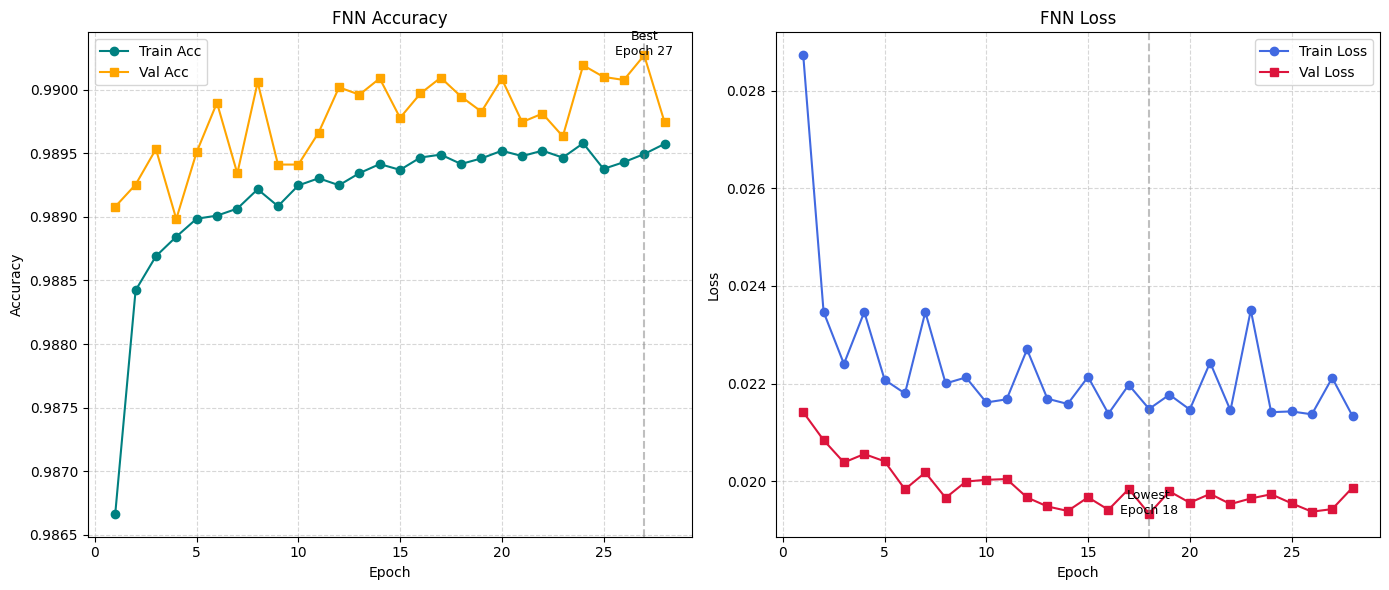

In [ ]:
def plot_fnn_training(history):
    e = range(1, len(history.history['accuracy']) + 1)
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    best_acc, best_loss = np.argmax(val_acc) + 1, np.argmin(val_loss) + 1

    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(e, acc, 'o-', label='Train Acc', color='teal')
    plt.plot(e, val_acc, 's-', label='Val Acc', color='orange')
    plt.axvline(best_acc, ls='--', color='gray', alpha=0.5)
    plt.text(best_acc, val_acc[best_acc-1], f'Best\nEpoch {best_acc}', ha='center', fontsize=9)
    plt.title('FNN Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(ls='--', alpha=0.5)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(e, loss, 'o-', label='Train Loss', color='royalblue')
    plt.plot(e, val_loss, 's-', label='Val Loss', color='crimson')
    plt.axvline(best_loss, ls='--', color='gray', alpha=0.5)
    plt.text(best_loss, val_loss[best_loss-1], f'Lowest\nEpoch {best_loss}', ha='center', fontsize=9)
    plt.title('FNN Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.grid(ls='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_fnn_training(history)


### **Confusion Matrix**

True Negatives(TN) 389919
False Positives(FP) 2016
False Negatives(FN) 2070
True Positives(TP) 17857


<Figure size 600x600 with 0 Axes>

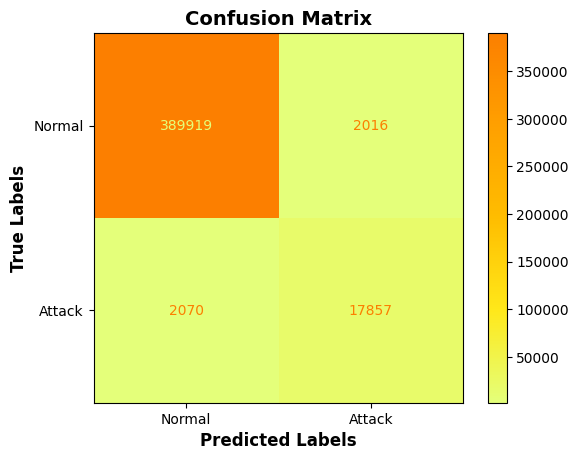

In [ ]:
#confusion Matrix
cm_fnn = confusion_matrix(y_test_fnn, fnn_pred)
disp_fnn = ConfusionMatrixDisplay(confusion_matrix=cm_fnn, display_labels=['Normal', 'Attack'])
#Extracting TP, TN, FP, FN
tn_fnn, fp_fnn, fn_fnn, tp_fnn = cm_fnn.ravel()
#Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
disp_fnn.plot(cmap='Wistia')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.grid(False)
#Printing TP, TN, FB, FN
print(f'True Negatives(TN)', tn_fnn)
print(f'False Positives(FP)', fp_fnn)
print(f'False Negatives(FN)', fn_fnn)
print(f'True Positives(TP)', tp_fnn)


### **Precision Recall Curve**

Precision Recall Curve is helpful with imbalanced datasets. It focuses on the performance of the model with respect to positive class (e.g. attacks)

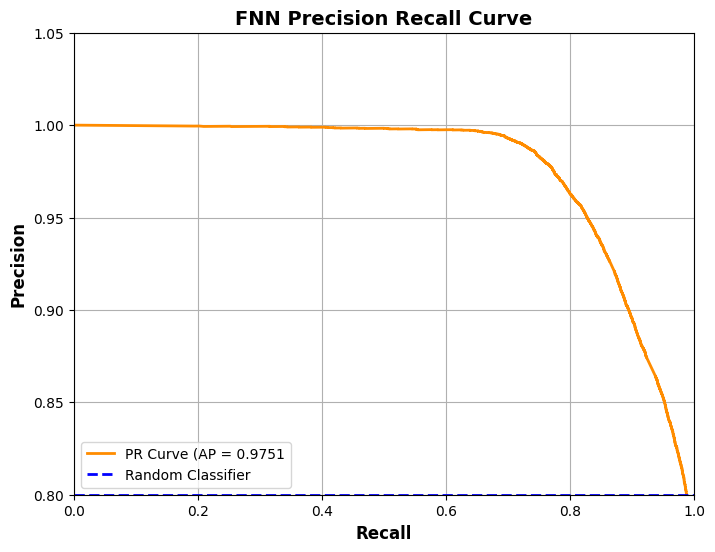

In [ ]:
#Probabilities predictions and true label
y_true_fnn = y_test_fnn.astype(int).values
y_proba_fnn = fnn_probs.flatten()
#Calculating Precision Recall and average Precision score
precision_fnn, recall_fnn, threaholds_fnn = precision_recall_curve(y_true_fnn, y_proba_fnn)
average_precision_fnn = average_precision_score(y_true_fnn, y_proba_fnn)
#Plotting the PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_fnn, precision_fnn, color='darkorange', lw=2, label=f'PR Curve (AP = {average_precision_fnn:.4f}')
plt.plot([0, 1], [0.8, 0.8], color='blue', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.8, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('FNN Precision Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


### **Histogram**
A Histogram is a bar chart that shows the distribution of values. In this case, the predicted probabitilites by FNN model. These probabilities represent the models' confidence in classifying a sample as either 'attack' or 'normal'.

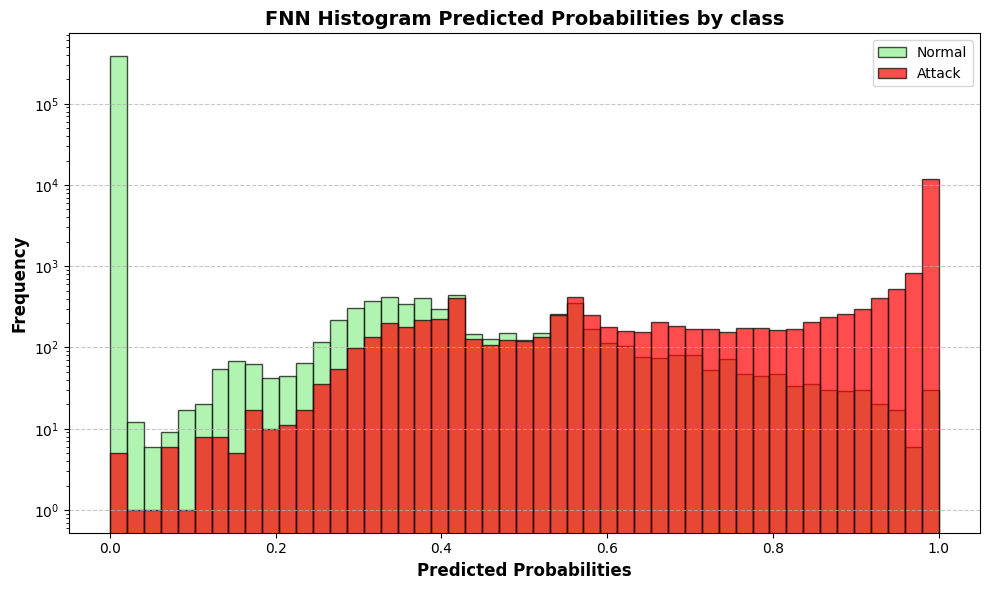

In [ ]:
# Ensuring y_test_fnn and fnn_probas are nump arrays
y_test_fnn = np.array(y_test_fnn).astype(int)
fnn_probs = fnn_probs.flatten()
#Predicted Prbabilities for each class
probas_attack = fnn_probs[y_test_fnn == 1]
probas_normal = fnn_probs[y_test_fnn == 0]
#Plotting Histogram
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 50)
plt.hist(probas_normal, bins=bins, alpha=0.7, label='Normal', color='lightgreen', edgecolor='black')
plt.hist(probas_attack, bins=bins, alpha=0.7, label='Attack', color='red', edgecolor='black')
plt.xlabel('Predicted Probabilities', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'FNN Histogram Predicted Probabilities by class', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **FNN Histogram Stacked**

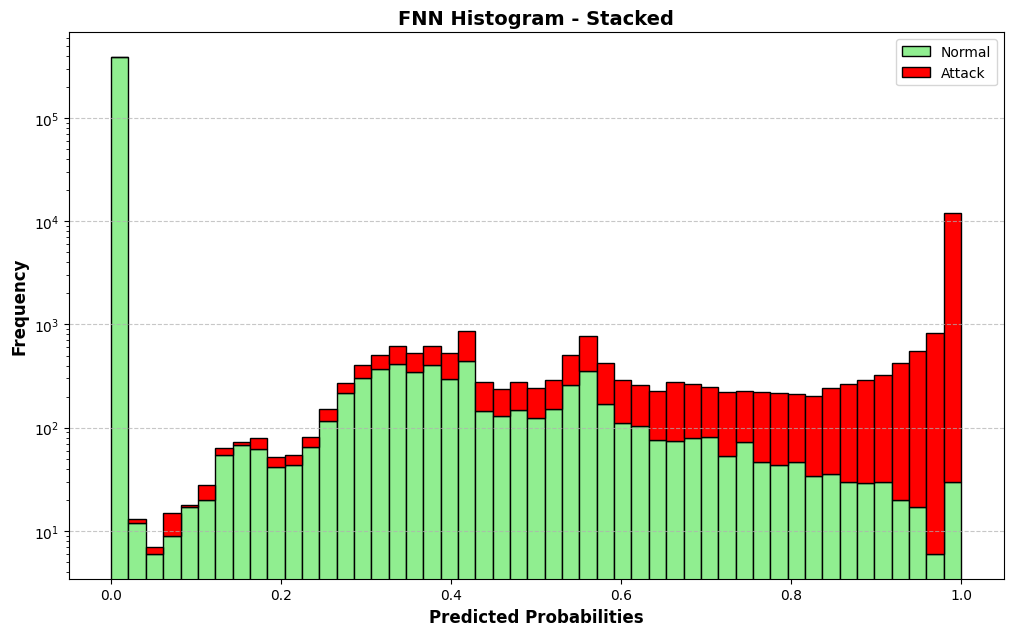

In [ ]:
#Ploting Stacked Histogram
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 50)
data = [probas_normal, probas_attack]
labels = ['Normal', 'Attack']
colors = ['lightgreen', 'red']
plt.hist(data, bins=bins, label=labels, color=colors, stacked=True, edgecolor='black')
plt.yscale('log')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xlabel('Predicted Probabilities', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'FNN Histogram - Stacked', fontsize=14, fontweight='bold')
plt.show()

### **Normal Histogram (percentage view)**

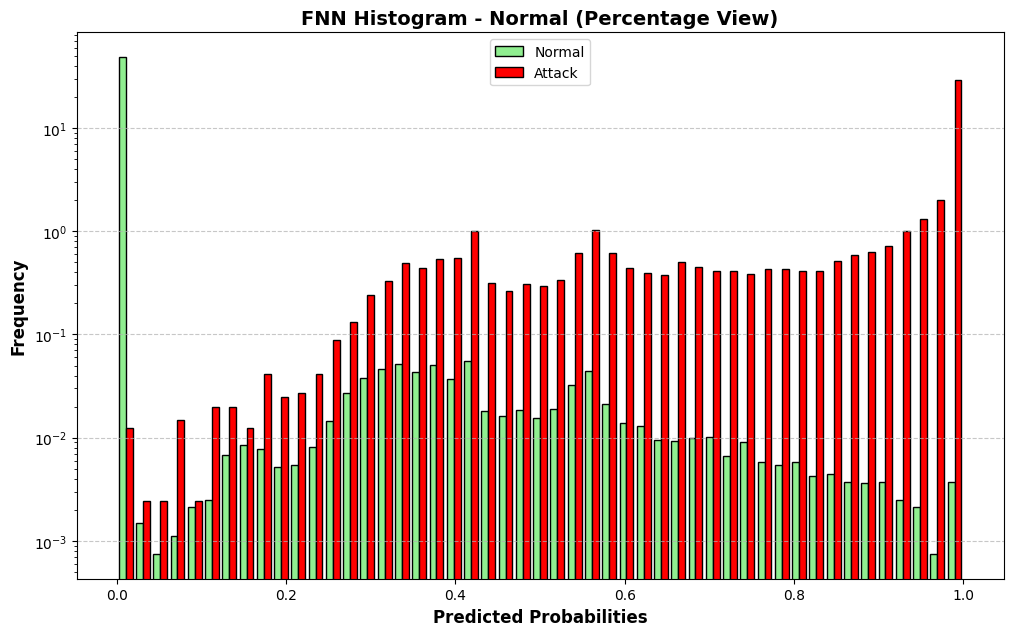

In [ ]:
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 50)
data = [probas_normal, probas_attack]
labels = ['Normal', 'Attack']
colors = ['lightgreen', 'red']
plt.hist(data, bins=bins, label=labels, color=colors, density=True, edgecolor='black')
plt.yscale('log')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xlabel('Predicted Probabilities', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'FNN Histogram - Normal (Percentage View)', fontsize=14, fontweight='bold')
plt.show()

### **Model fine Tuning**
We will fine tuning FNN model by using Keras Tuner.
### **Keras Tuner**
Keras tuner is an open-source library developed by the Keras team. It is designed to to automate and optimize the hyperparameter tuning process for deep learning models bulit with TensorFlow/Keras.

Keras tuner is optimal for FeedForward Nerual Network because it is simple and compatible, and at efficient searching. We can also choose which tuner the strategy works best for our model, Randomsearch or Hyperband.
### **Hyperband**
We are using Hyperband. Because it has a better search strategy. Combines random search with early stoping, drops poor perfomners early, resource efficient, uses few, best for larger models like FNN, faster with more epochs and stops bad models early.

In [40]:
#Defining the model builder function
def build_fnn_model(hp):
    model = Sequential()
    model.add( keras.Input(shape=(X_train_fnn.shape[1],))) #Input Layer
    #Number of layers for tuning
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        ))
        model.add(layers.Dense(1, activation='sigmoid')) #Output Layer
        #Tuning the optimizer and learning rate
        optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        optimizer = keras.optimizers.get({
            'class_name' : optimizer,
            'config' : {
                'learning_rate' : learning_rate
            }
        })
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    return model
#Hyperband tuner instantitate
tuner = kt.Hyperband(
    build_fnn_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='fnn_hyperband_tuning',
    project_name='AI_IDS'
)
#Early stopping if accuracy does not improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#Search for best hyperparameters
tuner.search(
    X_train_fnn,
    y_train_fnn,
    epochs=30,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2
    )


Trial 90 Complete [00h 10m 14s]
val_accuracy: 0.9893957376480103

Best val_accuracy So Far: 0.9912865161895752
Total elapsed time: 10h 51m 08s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/30
41187/41187 - 88s - 2ms/step - accuracy: 0.9913 - loss: 0.0176 - val_accuracy: 0.9912 - val_loss: 0.0182
Epoch 2/30
41187/41187 - 87s - 2ms/step - accuracy: 0.9914 - loss: 0.0175 - val_accuracy: 0.9912 - val_loss: 0.0181
Epoch 3/30
41187/41187 - 88s - 2ms/step - accuracy: 0.9914 - loss: 0.0175 - val_accuracy: 0.9911 - val_loss: 0.0183
Epoch 4/30
41187/41187 - 88s - 2ms/step - accuracy: 0.9913 - loss: 0.0175 - val_accuracy: 0.9912 - val_loss: 0.0179
Epoch 5/30
41187/41187 - 90s - 2ms/step - accuracy: 0.9914 - loss: 0.0174 - val_accuracy: 0.9912 - val_loss: 0.0180
Epoch 6/30
41187/41187 - 88s - 2ms/step - accuracy: 0.9914 - loss: 0.0174 - val_accuracy: 0.9913 - val_loss: 0.0181
Epoch 7/30
41187/41187 - 86s - 2ms/step - accuracy: 0.9915 - loss: 0.0174 - val_accuracy: 0.9912 - val_loss: 0.0181
Epoch 8/30
41187/41187 - 86s - 2ms/step - accuracy: 0.9915 - loss: 0.0173 - val_accuracy: 0.9911 - val_loss: 0.0181
Epoch 9/30
41187/41187 - 87s - 2ms/step - accuracy: 0.9914 - loss: 0.017

### **Model Training with Hyperparameters**
We will train the FNN model again with the best patameters we found with hyperband tunning.

In [59]:
#Best Model
best_fnn = tuner.get_best_models(num_models=1)[0]
best_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]
#Training model with best hyperparameters
history = best_fnn.fit(
    X_train_fnn,
    y_train_fnn,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2
    )
#Prediction on test data
fnn_probs_tuned = best_fnn.predict(X_test_fnn)
fnn_pred_tuned = (fnn_probs_tuned >= 0.5).astype(int).flatten()
#y_test format
y_test_fnn = y_test_fnn.astype(int).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
41187/41187 - 96s - 2ms/step - accuracy: 0.9913 - loss: 0.0176 - val_accuracy: 0.9912 - val_loss: 0.0180
Epoch 2/10
41187/41187 - 93s - 2ms/step - accuracy: 0.9913 - loss: 0.0175 - val_accuracy: 0.9913 - val_loss: 0.0180
Epoch 3/10
41187/41187 - 92s - 2ms/step - accuracy: 0.9914 - loss: 0.0175 - val_accuracy: 0.9911 - val_loss: 0.0181
Epoch 4/10
41187/41187 - 91s - 2ms/step - accuracy: 0.9914 - loss: 0.0175 - val_accuracy: 0.9911 - val_loss: 0.0183
Epoch 5/10
41187/41187 - 89s - 2ms/step - accuracy: 0.9913 - loss: 0.0174 - val_accuracy: 0.9911 - val_loss: 0.0184
Epoch 6/10
41187/41187 - 91s - 2ms/step - accuracy: 0.9913 - loss: 0.0174 - val_accuracy: 0.9913 - val_loss: 0.0179
Epoch 7/10
41187/41187 - 91s - 2ms/step - accuracy: 0.9914 - loss: 0.0174 - val_accuracy: 0.9913 - val_loss: 0.0181
Epoch 8/10
41187/41187 - 90s - 2ms/step - accuracy: 0.9914 - loss: 0.0173 - val_accuracy: 0.9912 - val_loss: 0.0179
Epoch 9/10
41187/41187 - 91s - 2ms/step - accuracy: 0.9915 - loss: 0.017

Evalution of test data
We will use accuracy, precision, recall, and f1-score to evaluate the performace of best fnn model.

In [60]:
#Model Evalution
print('Tunned FNN Model Evalution:')
print('Accuracy', accuracy_score(y_test_fnn, fnn_pred_tuned))
print('Precision', precision_score(y_test_fnn, fnn_pred_tuned))
print('Recall', recall_score(y_test_fnn, fnn_pred_tuned))
print('F1 Score', f1_score(y_test_fnn, fnn_pred_tuned))
print('\n Classification Report:\n')
print(classification_report(y_test_fnn, fnn_pred_tuned))

Tunned FNN Model Evalution:
Accuracy 0.9912325002063798
Precision 0.9175880425880426
Recall 0.8995834797009084
F1 Score 0.9084965664039734

 Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    391935
           1       0.92      0.90      0.91     19927

    accuracy                           0.99    411862
   macro avg       0.96      0.95      0.95    411862
weighted avg       0.99      0.99      0.99    411862



### **Plotting the results**
We will plot the outputs to visualize the accuracy of the tuned fnn model.
### **Training/validation loss and accuracy**


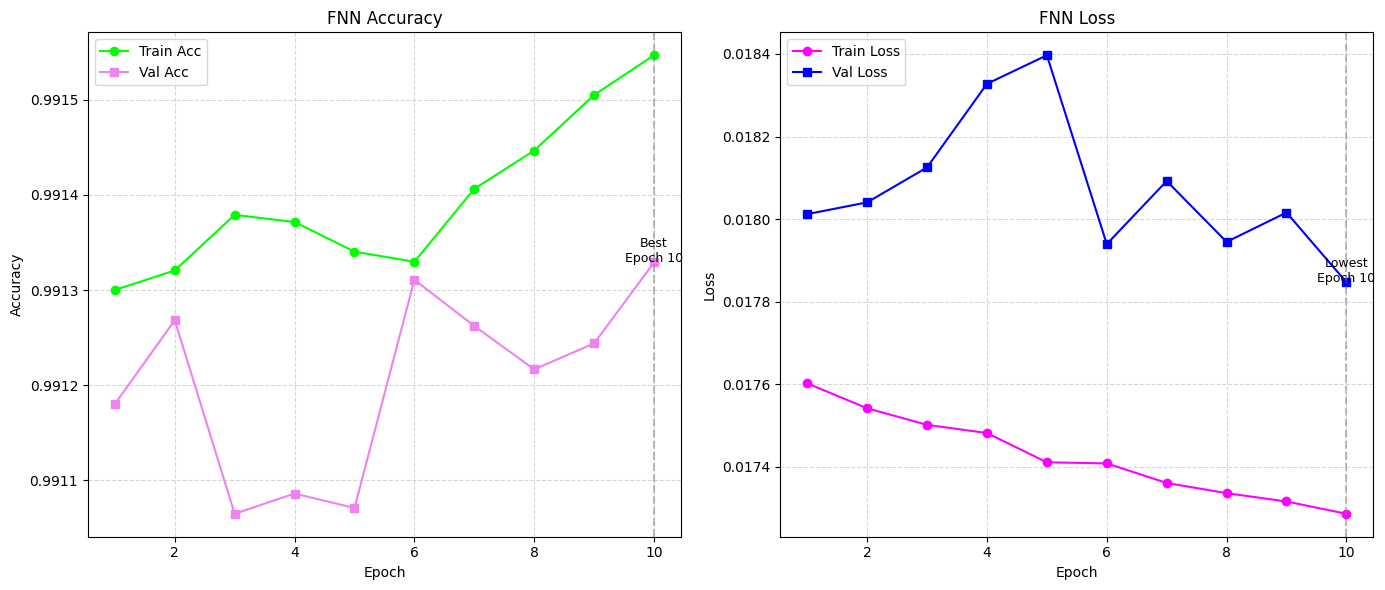

In [61]:
#Function for plotting Training/validation loss and accuracy
def plot_fnn_tuned_training(history):
  #Extracting number of epochs bsaed on the training history
  e = range(1, len(history.history['accuracy']) + 1)
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
  loss, val_loss = history.history['loss'], history.history['val_loss']
  best_acc, best_loss = np.argmax(val_acc) + 1, np.argmin(val_loss) + 1

  plt.figure(figsize=(14, 6))

  # Accuracy Plot
  plt.subplot(1, 2, 1)
  plt.plot(e, acc, 'o-', label='Train Acc', color='lime')
  plt.plot(e, val_acc, 's-', label='Val Acc', color='violet')
  plt.axvline(best_acc, ls='--', color='gray', alpha=0.5)
  plt.text(best_acc, val_acc[best_acc-1], f'Best\nEpoch {best_acc}', ha='center', fontsize=9)
  plt.title('FNN Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
  plt.legend(); plt.grid(ls='--', alpha=0.5)

  # Loss Plot
  plt.subplot(1, 2, 2)
  plt.plot(e, loss, 'o-', label='Train Loss', color='magenta')
  plt.plot(e, val_loss, 's-', label='Val Loss', color='blue')
  plt.axvline(best_loss, ls='--', color='gray', alpha=0.5)
  plt.text(best_loss, val_loss[best_loss-1], f'Lowest\nEpoch {best_loss}', ha='center', fontsize=9)
  plt.title('FNN Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
  plt.legend(); plt.grid(ls='--', alpha=0.5)
  #Plots layout adjustment to prevent overlap
  plt.tight_layout()
  plt.show()
#Function calling
plot_fnn_tuned_training(history)

### **Confusion Matrix**

<Figure size 600x600 with 0 Axes>

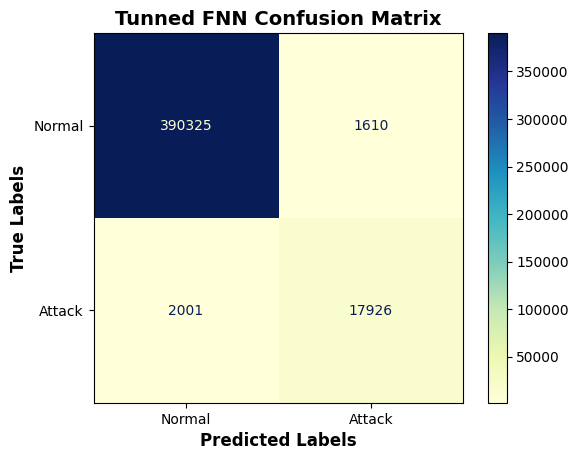

True Negatives(TN) 390325
False Positives(FP) 1610
False Negatives(FN) 2001
True Positives(TP) 17926


In [106]:
#Computing confusion matrix
cm_fnn_tuned = confusion_matrix(y_test_fnn, fnn_pred_tuned)
#Extracting TP, TN, FP, FN
tn_fnn_tuned, fp_fnn_tuned, fn_fnn_tuned, tp_fnn_tuned = cm_fnn_tuned.ravel()
#Plotting the confusion matrix
plt.figure(figsize=(6, 6))
disp_fnn_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_fnn_tuned, display_labels=['Normal', 'Attack'])
disp_fnn_tuned.plot(cmap='YlGnBu', values_format='d')
plt.title('Tunned FNN Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.grid(False)
plt.show()
#Printing TP, TN, FB, FN
print(f'True Negatives(TN)', tn_fnn_tuned)
print(f'False Positives(FP)', fp_fnn_tuned)
print(f'False Negatives(FN)', fn_fnn_tuned)
print(f'True Positives(TP)', tp_fnn_tuned)

### **Precision Recall Curve**

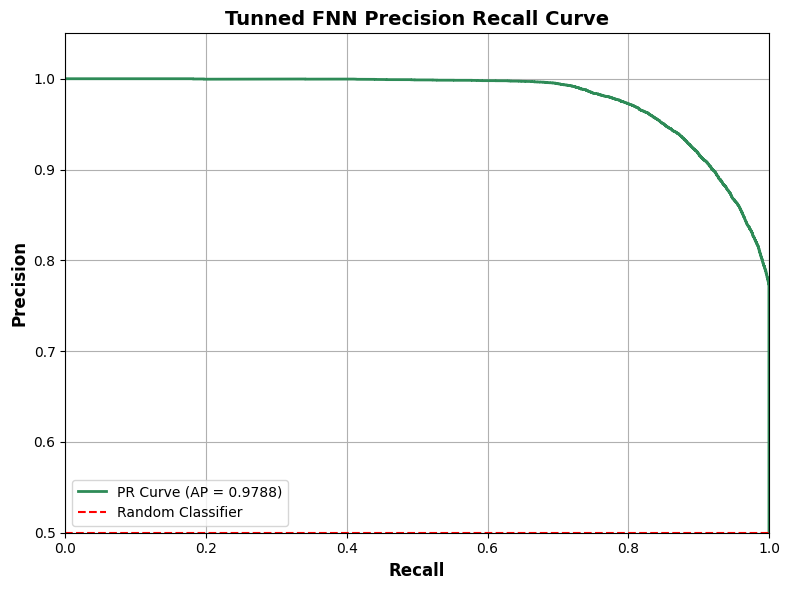

In [67]:
#Calculating precision, recall and average precision
precision_fnn_tuned, recall_fnn_tuned, threaholds_fnn_tuned = precision_recall_curve(y_test_fnn, fnn_probs_tuned)
average_precision_fnn_tuned = average_precision_score(y_test_fnn, fnn_probs_tuned)
#Plotting Precision Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_fnn_tuned, precision_fnn_tuned, color='seagreen', lw=2, label=f'PR Curve (AP = {average_precision_fnn_tuned:.4f})')
plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.5, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Tunned FNN Precision Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Histogram Stacked**

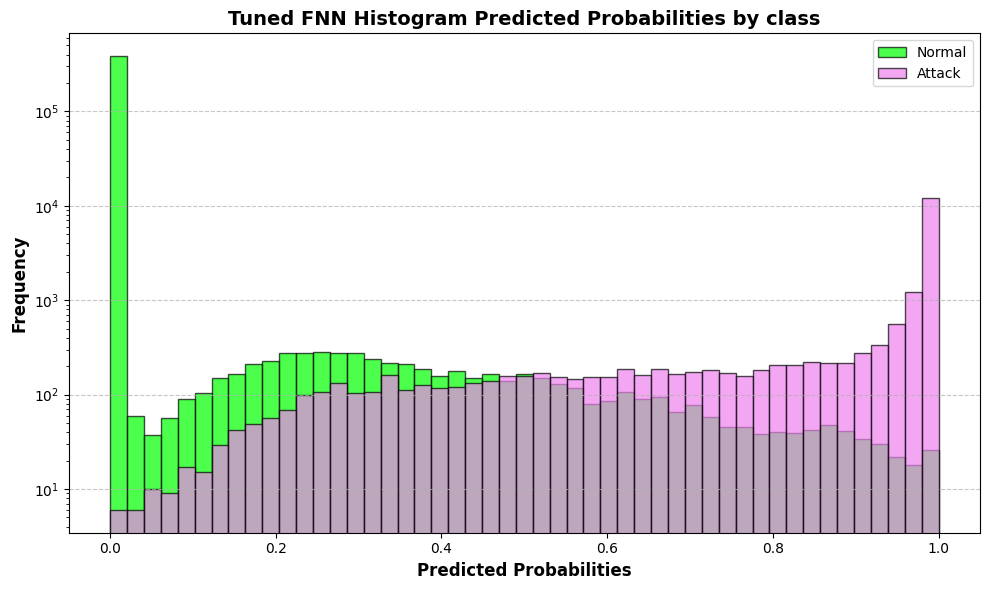

In [71]:
# Predicting Probabilities for each class
tuned_probas_attack = fnn_probs_tuned[y_test_fnn == 1]
tuned_probas_normal = fnn_probs_tuned[y_test_fnn == 0]
#Plotting Histogram
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 50)
plt.hist(tuned_probas_normal, bins=bins, alpha=0.7, label='Normal', color='lime', edgecolor='black')
plt.hist(tuned_probas_attack, bins=bins, alpha=0.7, label='Attack', color='violet', edgecolor='black')
plt.xlabel('Predicted Probabilities', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'Tuned FNN Histogram Predicted Probabilities by class', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Normal Histogram (percentage view)**

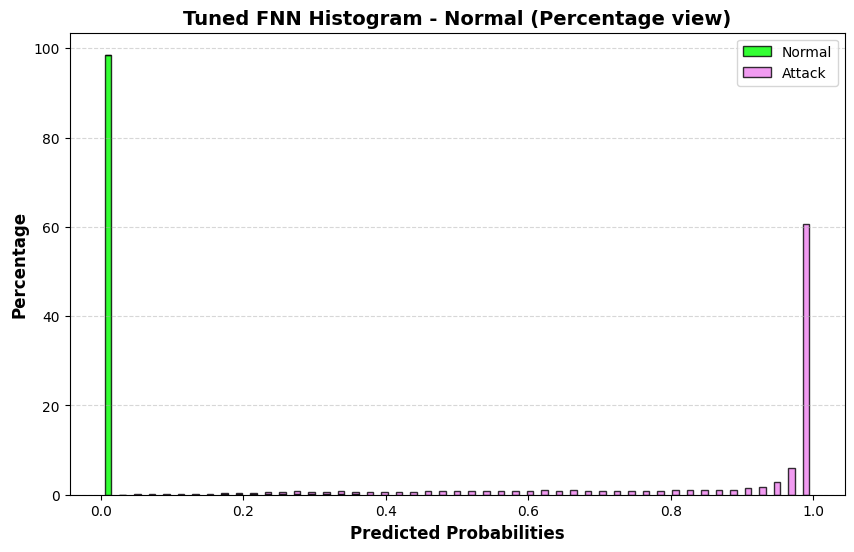

In [104]:
#Combining predictions for consisting binning
all_probas_tuned = np.concatenate([tuned_probas_normal, tuned_probas_attack])
#Defining Bins
bins = np.linspace(0, 1, 50)
#Histogram counting for each class
counts_normal, _ = np.histogram(tuned_probas_normal, bins=bins)
counts_attack, _ = np.histogram(tuned_probas_attack, bins=bins)
#Calculating percentage
percentage_normal = counts_normal / counts_normal.sum() * 100
percentage_attack = counts_attack / counts_attack.sum() * 100
#Calculating bin centres
bin_centers = (bins[:-1] + bins[1:]) / 2
bar_width = (bins[1] - bins[0]) * 0.45
#Plotting Histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, percentage_normal, width=bar_width, label='Normal', alpha=0.8, color='lime', edgecolor='black')
plt.bar(bin_centers, percentage_attack, width=bar_width, label='Attack', alpha=0.8, color='violet', edgecolor='black', bottom=percentage_normal)
plt.title('Tuned FNN Histogram - Normal (Percentage view)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Probabilities', fontsize=12, fontweight='bold')
plt.ylabel('Percentage', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## **Comparison of FNN and Tunned FNN Models**
We will compare the performance of both untuned and tuned fnn models. And will plot the comparison to understand the difference between the performacne.
### **1. Comparing Training/Validation Loss and Accuracy**

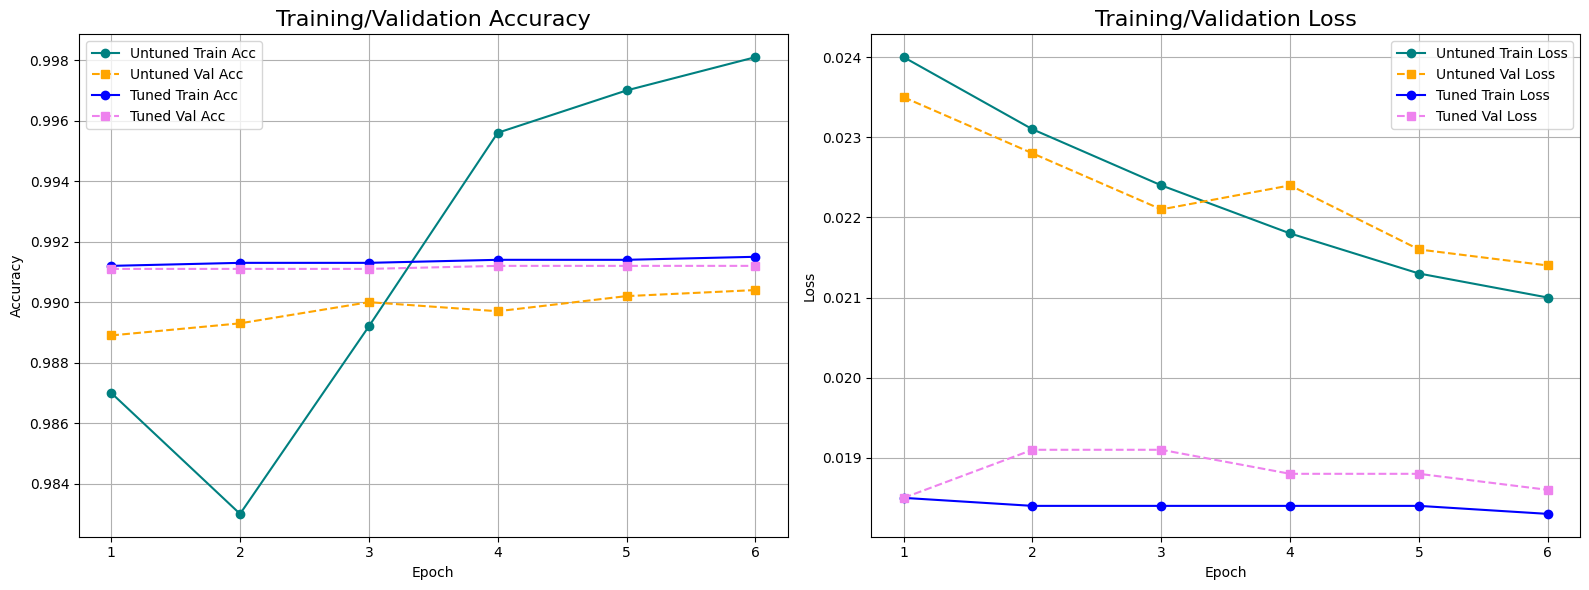

In [119]:
#Epoch Range
epochs = list(range(1, 7))
# Untuned FNN performance
untuned_train_acc = [0.987, 0.983, 0.9892, 0.9956, 0.997, 0.9981]
untuned_val_acc   = [0.9889, 0.9893, 0.99, 0.9897, 0.9902, 0.9904]
untuned_train_loss = [0.024, 0.0231, 0.0224, 0.0218, 0.0213, 0.0210]
untuned_val_loss   = [0.0235, 0.0228, 0.0221, 0.0224, 0.0216, 0.0214]
# Tuned FNN performance
tuned_train_acc = [0.9912, 0.9913, 0.9913, 0.9914, 0.9914, 0.9915]
tuned_val_acc   = [0.9911, 0.9911, 0.9911, 0.9912, 0.9912, 0.9912]
tuned_train_loss = [0.0185, 0.0184, 0.0184, 0.0184, 0.0184, 0.0183]
tuned_val_loss   = [0.0185, 0.0191, 0.0191, 0.0188, 0.0188, 0.0186]
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Accuracy subplot
axes[0].plot(epochs, untuned_train_acc, label='Untuned Train Acc', marker='o', color='teal')
axes[0].plot(epochs, untuned_val_acc, label='Untuned Val Acc', marker='s', linestyle='--', color='orange')
axes[0].plot(epochs, tuned_train_acc, label='Tuned Train Acc', marker='o', color='blue')
axes[0].plot(epochs, tuned_val_acc, label='Tuned Val Acc', marker='s', linestyle='--', color='violet')
axes[0].set_title('Training/Validation Accuracy', fontsize=16)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)
# Loss subplot
axes[1].plot(epochs, untuned_train_loss, label='Untuned Train Loss', marker='o', color='teal')
axes[1].plot(epochs, untuned_val_loss, label='Untuned Val Loss', marker='s', linestyle='--', color='orange')
axes[1].plot(epochs, tuned_train_loss, label='Tuned Train Loss', marker='o', color='blue')
axes[1].plot(epochs, tuned_val_loss, label='Tuned Val Loss', marker='s', linestyle='--', color='violet')
axes[1].set_title('Training/Validation Loss', fontsize=16)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()